# Evaluating BGP catchment on Tangled testbed
* Joao Ceron - ceron@botlog.org

In [150]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
plt.style.use('default')
from IPython.core.display import display, HTML
%matplotlib inline
from matplotlib import ticker
import os.path
import re
import numpy as pynum_float


In [151]:
# convert names to airport code
di = {"UK-LND": "LHR", 
      'US-MIA':"MIA", 
      "AU-SYD":"SYD",
      'FR-PAR': "CDG",
      'baseline': 'baseline'
     }

---
---
<h1 align="center">Functions</h1>

---
---

In [152]:
def init_fig():
    
    fig = plt.figure(figsize=(12, 5))
    ax = plt.subplot(111)   
    ax = plt.subplot2grid((1,1), (0,0))
    
    # style 
#     plt.gca().legend().set_title('')
    ax.set_facecolor("#ffffff")

    ax.spines['bottom'].set_color('0.5')
    ax.spines['top'].set_color('0.5')
    ax.spines['right'].set_color('0.5')
    ax.spines['left'].set_color('0.5')
    fig.tight_layout();
    plt.style.use('default')
    
    return (fig,ax)

In [153]:
def get_and_plot_reference_value(df,site):

    
    df_site = df[df['site']==site].sort_values(by="bgp")
    reference_value = df_site[df_site.bgp=="baseline"].iloc[0,2]

    label = "[{}%] BASELINE".format(int(reference_value))
    # reference value annotation
    ax.annotate(label,xy=(25, reference_value), ha='right',color='black',va='bottom')
    # reference value line
    ax.axhline(y=reference_value, xmin=-1, xmax=1.0, color='grey', linestyle='dotted')

    return (reference_value)

In [154]:
!pwd

/Users/joaoceron/work/SAND/paper_bgp_catchment_manipulation/data_analysis/server_load


# Read files and build dataframe

In [155]:
# get files, parse them and use their names

df_all = pd.DataFrame()
df_raw = pd.DataFrame()
dir   = "./stats_files/load-2019-11-06-1573066000/*load*.txt"
for file in (glob.glob(dir)):
    
    filename = os.path.basename(file)
    print (filename)
    
    # get baseline file - anycast with no prepends 
    if (bool(re.search('baseline', filename))):           
        df = pd.read_csv(file,names=['data'],skiprows=1)  
        df = df.data.str.split("█",expand=True)[0].str.split("[|\-]",expand=True)
        df_raw['site'] = df.iloc[:,0].str.upper() + "-" +  df.iloc[:,1].str.upper()
        df_raw['count'] = df.iloc[:,3].astype(int)
        df_raw['percent'] = df_raw['count']/df_raw['count'].sum()*100
        df_raw['bgp'] = "baseline"
        df_raw['site'] = df_raw.site.map(di)
        df_raw['type'] = None

    # get other files - with prepends
    else:
        bgp = file.split(".")[0].split("-") 
        bgp_policy = filename.split(".")[0].split("-")[3]
        bgp_site = filename.split(".")[0].split("-")[4].upper()+"-"+filename.split(".")[0].split("-")[5].upper()
        bgp = filename.split(".")[0].split("-")[2]+filename.split(".")[0].split("-")[3].upper()+"-"+filename.split(".")[0].split("-")[4].upper()
        df = pd.read_csv(file,names=['data'],skiprows=1)  
        df = df.data.str.split("█",expand=True)[0].str.split("[|\-]",expand=True)
        df_raw['site'] = df.iloc[:,0].str.upper() + "-" +  df.iloc[:,1].str.upper()
        df_raw['count'] = df.iloc[:,3].astype(int)
        df_raw['bgp_policy'] = bgp_policy
        df_raw['bgp_site'] = bgp_site
        df_raw['type'] = filename.split(".")[0].split("-")[1]
        
        df_raw['percent'] = df_raw['count']/df_raw['count'].sum()*100
        df_raw['bgp'] = bgp
        df_raw['site'] = df_raw.site.map(di)
        df_raw['bgp_site'] = df_raw.bgp_site.map(di)
        df_raw['bgp'] = df_raw['bgp_policy']+df_raw['bgp_site']
        df_raw.drop(['bgp_site','bgp_policy'],axis=1,inplace=True)
        print (df_raw)
    df_all = pd.concat([df_raw, df_all],sort=False)

df_all.head(300)

load-positive-prepend-2x-uk-lnd.txt
  site    count      type    percent    bgp
0  MIA  1384390  positive  39.535023  2xLHR
1  CDG   930161  positive  26.563278  2xLHR
2  SYD   693975  positive  19.818344  2xLHR
3  LHR   493154  positive  14.083354  2xLHR
load-positive-prepend-3x-au-syd.txt
  site    count      type    percent    bgp
0  LHR  1421868  positive  39.641719  3xSYD
1  MIA  1416267  positive  39.485563  3xSYD
2  CDG   696633  positive  19.422147  3xSYD
3  SYD    52029  positive   1.450570  3xSYD
load-positive-prepend-5x-us-mia.txt
  site    count      type    percent    bgp
0  LHR  1830045  positive  51.135216  5xMIA
1  SYD   998288  positive  27.894217  5xMIA
2  CDG   595070  positive  16.627478  5xMIA
3  MIA   155432  positive   4.343089  5xMIA
load-negative-prepend-3x-us-mia.txt
  site    count      type    percent    bgp
0  LHR  2138061  negative  59.983100  3xMIA
1  SYD   973784  negative  27.319418  3xMIA
2  CDG   452594  negative  12.697482  3xMIA
3  MIA        0  neg

site    count      type    percent    bgp
0   MIA  1418891  positive  40.672346  5xLHR
1   CDG  1040796  positive  29.834297  5xLHR
2   SYD   700082  positive  20.067770  5xLHR
3   LHR   328820  positive   9.425587  5xLHR
0   LHR  2134984  negative  60.249539  1xMIA
..  ...      ...       ...        ...    ...
3   SYD    52029  positive   1.450570  3xSYD
0   MIA  1384390  positive  39.535023  2xLHR
1   CDG   930161  positive  26.563278  2xLHR
2   SYD   693975  positive  19.818344  2xLHR
3   LHR   493154  positive  14.083354  2xLHR

[108 rows x 5 columns]

In [156]:
df_full = df_all
df_all = df_all[df_all['type']!="negative"]

In [157]:
data = df_all.groupby(['site','bgp'])['percent'].sum().unstack().T.fillna(0)
# data= data.reindex(['3xMIA','2xMIA','1xMIA','3xLHR','2xLHR','1xLHR','3xCDG','2xCDG',
#                     '1xCDG','3xSYD','2xSYD','1xSYD','baseline'])
# data.groupby('bgp').size()
df_all

site    count      type    percent    bgp
0   MIA  1418891  positive  40.672346  5xLHR
1   CDG  1040796  positive  29.834297  5xLHR
2   SYD   700082  positive  20.067770  5xLHR
3   LHR   328820  positive   9.425587  5xLHR
0   MIA  1398557  positive  39.143272  4xSYD
..  ...      ...       ...        ...    ...
3   SYD    52029  positive   1.450570  3xSYD
0   MIA  1384390  positive  39.535023  2xLHR
1   CDG   930161  positive  26.563278  2xLHR
2   SYD   693975  positive  19.818344  2xLHR
3   LHR   493154  positive  14.083354  2xLHR

[84 rows x 5 columns]

---
---
<h1 align="center">Catchment investigation using prepends</h1>

---
---

# General Overview

In [10]:
data = df_all.groupby(['site','bgp'])['percent'].sum().unstack().T.fillna(0)
data

site            CDG        LHR        MIA        SYD
bgp                                                 
1xCDG     14.274683  35.810110  31.299288  18.615919
1xLHR     11.126059  38.815068  31.532640  18.526234
1xMIA     11.135899  38.499419  31.811202  18.553480
1xSYD     14.180886  38.554021  28.524542  18.740552
2xCDG      1.297392  44.919471  34.458694  19.324442
2xLHR     26.563278  14.083354  39.535023  19.818344
2xMIA     16.237507  52.109733   5.379683  26.273078
2xSYD     15.609391  40.382570  42.555757   1.452281
3xCDG      0.980078  48.575681  31.529150  18.915091
3xLHR     29.720334   9.688790  40.647415  19.943461
3xMIA     17.699616  51.877979   4.748763  25.673642
3xSYD     19.422147  39.641719  39.485563   1.450570
4xCDG      0.965632  48.449043  31.388431  19.196893
4xLHR     30.021939   9.429421  40.838053  19.710587
4xMIA     17.822679  51.292805   4.459663  26.424852
4xSYD     20.804424  38.601614  39.143272   1.450691
5xCDG      0.901164  48.833540  30.843570  19.421726
5xLHR     29.834297   9.425587  40.672346  20.067770
5xMIA     16.627478  51.135216   4.343089  27.894217
5xSYD     20.825918  38.672320  39.044925   1.456837
baseline  13.859484  39.374557  28.726370  18.039589

In [11]:
data = pd.concat([data.tail(1),data.head(26)])
data

site            CDG        LHR        MIA        SYD
bgp                                                 
baseline  13.859484  39.374557  28.726370  18.039589
1xCDG     14.274683  35.810110  31.299288  18.615919
1xLHR     11.126059  38.815068  31.532640  18.526234
1xMIA     11.135899  38.499419  31.811202  18.553480
1xSYD     14.180886  38.554021  28.524542  18.740552
2xCDG      1.297392  44.919471  34.458694  19.324442
2xLHR     26.563278  14.083354  39.535023  19.818344
2xMIA     16.237507  52.109733   5.379683  26.273078
2xSYD     15.609391  40.382570  42.555757   1.452281
3xCDG      0.980078  48.575681  31.529150  18.915091
3xLHR     29.720334   9.688790  40.647415  19.943461
3xMIA     17.699616  51.877979   4.748763  25.673642
3xSYD     19.422147  39.641719  39.485563   1.450570
4xCDG      0.965632  48.449043  31.388431  19.196893
4xLHR     30.021939   9.429421  40.838053  19.710587
4xMIA     17.822679  51.292805   4.459663  26.424852
4xSYD     20.804424  38.601614  39.143272   1.450691
5xCDG      0.901164  48.833540  30.843570  19.421726
5xLHR     29.834297   9.425587  40.672346  20.067770
5xMIA     16.627478  51.135216   4.343089  27.894217
5xSYD     20.825918  38.672320  39.044925   1.456837
baseline  13.859484  39.374557  28.726370  18.039589

In [12]:
data = df_all.groupby(['site','bgp'])['percent'].sum().unstack().T.fillna(0)
data = pd.concat([data.tail(1),data.head(26)])
# data.iloc[::-1]
# data.reindex(index=data.index[::-1])
# data.sort_index(axis=1 ,ascending=False)
data.iloc[::-1]

site            CDG        LHR        MIA        SYD
bgp                                                 
baseline  13.859484  39.374557  28.726370  18.039589
5xSYD     20.825918  38.672320  39.044925   1.456837
5xMIA     16.627478  51.135216   4.343089  27.894217
5xLHR     29.834297   9.425587  40.672346  20.067770
5xCDG      0.901164  48.833540  30.843570  19.421726
4xSYD     20.804424  38.601614  39.143272   1.450691
4xMIA     17.822679  51.292805   4.459663  26.424852
4xLHR     30.021939   9.429421  40.838053  19.710587
4xCDG      0.965632  48.449043  31.388431  19.196893
3xSYD     19.422147  39.641719  39.485563   1.450570
3xMIA     17.699616  51.877979   4.748763  25.673642
3xLHR     29.720334   9.688790  40.647415  19.943461
3xCDG      0.980078  48.575681  31.529150  18.915091
2xSYD     15.609391  40.382570  42.555757   1.452281
2xMIA     16.237507  52.109733   5.379683  26.273078
2xLHR     26.563278  14.083354  39.535023  19.818344
2xCDG      1.297392  44.919471  34.458694  19.324442
1xSYD     14.180886  38.554021  28.524542  18.740552
1xMIA     11.135899  38.499419  31.811202  18.553480
1xLHR     11.126059  38.815068  31.532640  18.526234
1xCDG     14.274683  35.810110  31.299288  18.615919
baseline  13.859484  39.374557  28.726370  18.039589

In [17]:
data = df_all.groupby(['site','bgp'])['percent'].sum().unstack().T.fillna(0)
data = df_all.groupby(['site','bgp'])['percent'].sum().unstack().T.fillna(0)
data = pd.concat([data.tail(1),data.head(26)])
data = data.iloc[::-1]
data
# data = data.drop_duplicates(keep="first")

site            CDG        LHR        MIA        SYD
bgp                                                 
5xSYD     20.825918  38.672320  39.044925   1.456837
5xMIA     16.627478  51.135216   4.343089  27.894217
5xLHR     29.834297   9.425587  40.672346  20.067770
5xCDG      0.901164  48.833540  30.843570  19.421726
4xSYD     20.804424  38.601614  39.143272   1.450691
4xMIA     17.822679  51.292805   4.459663  26.424852
4xLHR     30.021939   9.429421  40.838053  19.710587
4xCDG      0.965632  48.449043  31.388431  19.196893
3xSYD     19.422147  39.641719  39.485563   1.450570
3xMIA     17.699616  51.877979   4.748763  25.673642
3xLHR     29.720334   9.688790  40.647415  19.943461
3xCDG      0.980078  48.575681  31.529150  18.915091
2xSYD     15.609391  40.382570  42.555757   1.452281
2xMIA     16.237507  52.109733   5.379683  26.273078
2xLHR     26.563278  14.083354  39.535023  19.818344
2xCDG      1.297392  44.919471  34.458694  19.324442
1xSYD     14.180886  38.554021  28.524542  18.

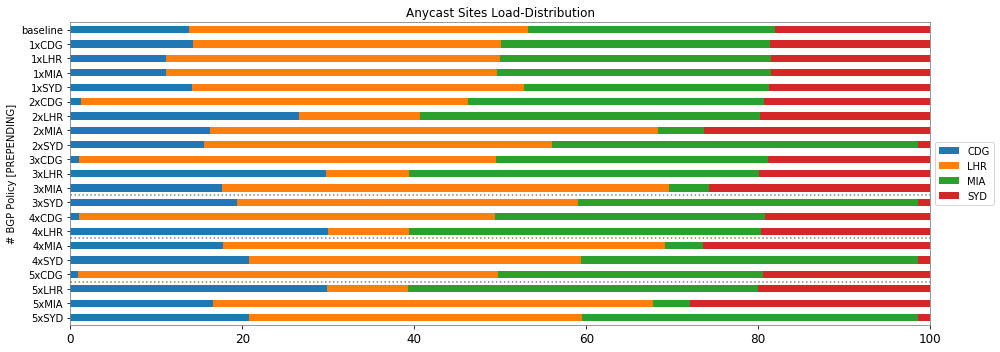

In [22]:
data = df_all.groupby(['site','bgp'])['percent'].sum().unstack().T.fillna(0)
data = pd.concat([data.tail(1),data.head(26)])
data = data.iloc[::-1]
data = data.drop_duplicates(keep="last")
print (data)
fig = plt.figure(figsize=(14, 5))
ax = plt.subplot2grid((1,1), (0,0))
data.plot(ax=ax,
        kind='barh', 
        stacked=True,
#           alpha=.8,
         );
ax.xaxis.label.set_color('black')
ax.set_ylabel('# BGP Policy [PREPENDING]');
ax.tick_params(colors='black')
ax.xaxis.set_tick_params(labelsize=12)
ax.set_title('Anycast Sites Load-Distribution')
plt.gca().legend().set_title('')
ax.set_facecolor("#ffffff")

ax.spines['bottom'].set_color('0.5')
ax.spines['top'].set_color('0.5')
ax.spines['right'].set_color('0.5')
ax.spines['left'].set_color('0.5')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5));
ax.set_xlim(xmax=100) 

# plot dashed line on the top
ax.axhline(y=25.5, xmin=-1, xmax=1.0, color='black',linestyle='--')
ax.axhline(y=8.5, xmin=-1, xmax=1.0, color='grey',linestyle='dotted')
ax.axhline(y=5.5, xmin=-1, xmax=1.0, color='grey',linestyle='dotted')
ax.axhline(y=2.5, xmin=-1, xmax=1.0, color='grey',linestyle='dotted')

fig.tight_layout();
xlabels = ax.get_xticklabels()

ax.set_xticklabels(xlabels, rotation=0);
plt.show()

fig.savefig("./../../images/general-prepend.pdf", bbox_inches='tight', dpi=1200)

title = "<h2 style=\"color:#000\">Evaluating changes in: {} </h2>".format(bgp.upper())
display(HTML("take-away: Prepending does impact in the load distribution"))



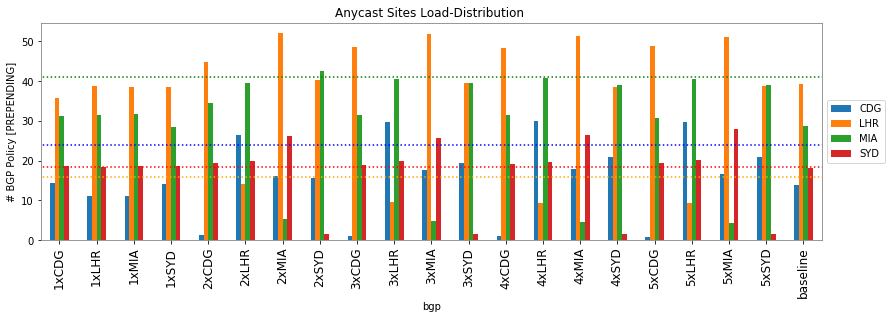

In [159]:
data = df_all.groupby(['site', 'bgp'])['percent'].sum().unstack().T

fig = plt.figure(figsize=(14, 4))
ax = plt.subplot2grid((1,1), (0,0))
data.plot(ax=ax,
    kind='bar', 
    stacked=False
     );
ax.xaxis.label.set_color('black')
ax.set_ylabel('# BGP Policy [PREPENDING]');
ax.tick_params(colors='black')
ax.xaxis.set_tick_params(labelsize=12)
title = 'Anycast Sites Load-Distribution '
ax.set_title(title)
plt.gca().legend().set_title('')
ax.set_facecolor("#ffffff")
xlabels = data.index.get_level_values(0).tolist()
ax.set_xticklabels(xlabels, rotation=90);
ax.spines['bottom'].set_color('0.5')
ax.spines['top'].set_color('0.5')
ax.spines['right'].set_color('0.5')
ax.spines['left'].set_color('0.5')
ax.axhline(y=18.5, xmin=-1, xmax=1.0, color='red',linestyle='dotted')
ax.axhline(y=41.0, xmin=-1, xmax=1.0, color='green',linestyle='dotted')
ax.axhline(y=16.0, xmin=-1, xmax=1.0, color='orange',linestyle='dotted')
ax.axhline(y=24.0, xmin=-1, xmax=1.0, color='blue',linestyle='dotted')


plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5));
# ax.set_xlim(xmax=100) 

# Sites Overview

In [160]:
def plot_site(df,site):
#     print (data.head())
    data = df.groupby(['site','bgp'])['percent'].sum().unstack().T.fillna(0)
    data.sort_index(inplace=True,ascending=False)

    fig = plt.figure(figsize=(10, 4))
    ax = plt.subplot2grid((1,1), (0,0))
    data.plot(ax=ax,
        kind='barh', 
        stacked=True
         );
    ax.xaxis.label.set_color('black')
    ax.set_ylabel('# BGP Policy [PREPENDING]');
    ax.tick_params(colors='black')
    ax.xaxis.set_tick_params(labelsize=12)
    title = 'Anycast Sites Load-Distribution - Site {}'.format(site)
    ax.set_title(title)
    plt.gca().legend().set_title('')
    ax.set_facecolor("#ffffff")

    ax.spines['bottom'].set_color('0.5')
    ax.spines['top'].set_color('0.5')
    ax.spines['right'].set_color('0.5')
    ax.spines['left'].set_color('0.5')
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5));
    ax.set_xlim(xmax=100) 

{'MIA', 'LHR', 'CDG', 'SYD'}


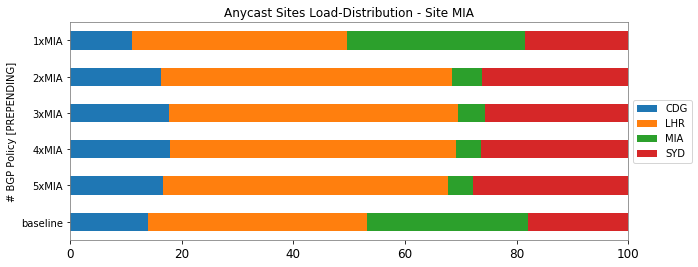

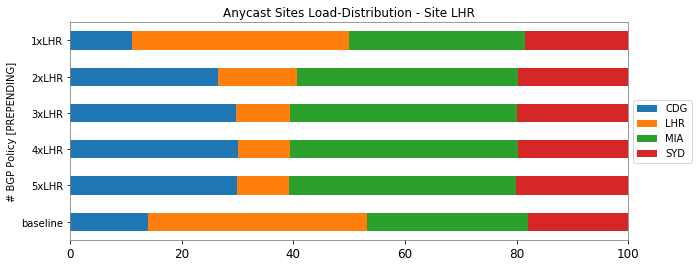

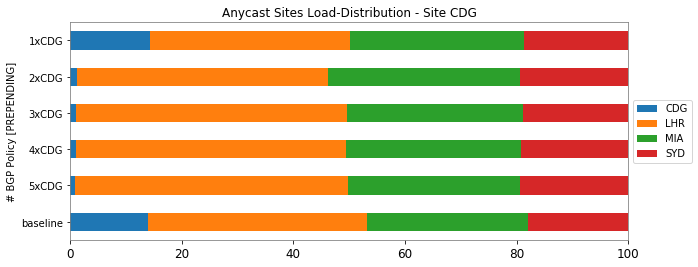

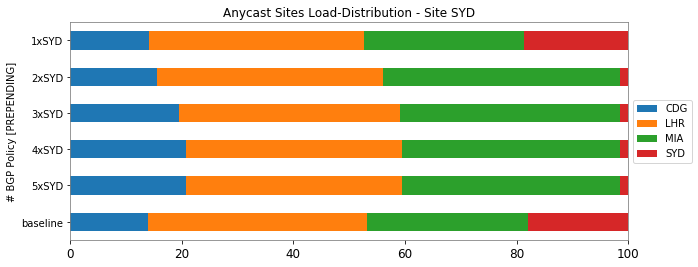

In [161]:
sites = []
for bgp in df_all['bgp'].unique():
    if (bgp=="baseline"):
        continue
    
    policy_site = bgp.split("x")[1]
    sites.append(policy_site)
print (set(sites))
sites=set(sites)
for bgp in sites:
    title = "<h2 style=\"color:#069\" >Evaluating changes in: {} </h2>".format(bgp.upper())
    display(HTML(title))
    data = df_all[df_all['bgp'].str.contains(bgp)]
    data = data.sort_values(by="bgp")
    data = data.append(df_all[df_all['bgp'].str.contains("baseline")])
    plot_site(data,bgp)
    plt.show()

In [162]:
def plot_site_bar(data, label,figure_name):

    fig = plt.figure(figsize=(10, 4))
    ax = plt.subplot2grid((1,1), (0,0))

    ax.xaxis.label.set_color('black')
    ax.set_ylabel('# Percent');
    ax.tick_params(colors='black')
    ax.xaxis.set_tick_params(labelsize=12)
    data= data.reindex(['LHR','SYD', 'MIA', 'CDG'])
    data['percent'].plot(ax=ax,kind='bar')
    ax.set_ylim(ymax=100);
    
    title = ' BGP Policy: {}'.format(label.upper())
    ax.set_title(title)
    xlabels = data.index.get_level_values(0).tolist()
    ax.set_xticklabels(xlabels, rotation=0);
#     fig.savefig("./imgs/"+figure_name+".png", bbox_inches='tight', dpi=1200)
    ax.set_facecolor("#ffffff")
    plt.gca().set_yticklabels(['{:.0f}%'.format(x*1) for x in plt.gca().get_yticks()]) 
    ax.set_ylabel('Percentage (%)')
    

# bar chart for each site

In [163]:
df_all.head()

site      count      type    percent    bgp
0  MIA  1418891.0  positive  40.672346  5xLHR
1  CDG  1040796.0  positive  29.834297  5xLHR
2  SYD   700082.0  positive  20.067770  5xLHR
3  LHR   328820.0  positive   9.425587  5xLHR
0  MIA  1398557.0  positive  39.143272  4xSYD

In [164]:
df_all[df_all['bgp'].str.contains(site)]['bgp'].unique().tolist()

['2xMIA', '1xMIA', '4xMIA', '3xMIA', '5xMIA']

In [165]:
df_all[df_all['bgp'].str.contains('3xMIA')].set_index('site')

count      type    percent    bgp
site                                       
LHR   1811592.0  positive  51.877979  3xMIA
SYD    896530.0  positive  25.673642  3xMIA
CDG    618075.0  positive  17.699616  3xMIA
MIA    165828.0  positive   4.748763  3xMIA

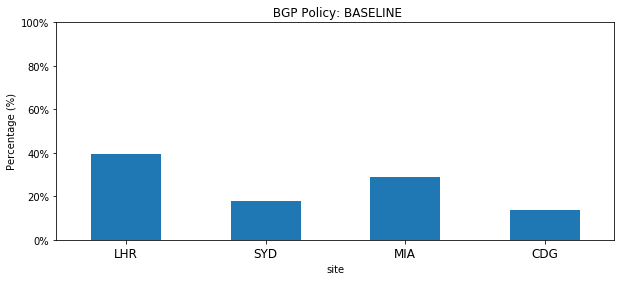

info for 1xMIA


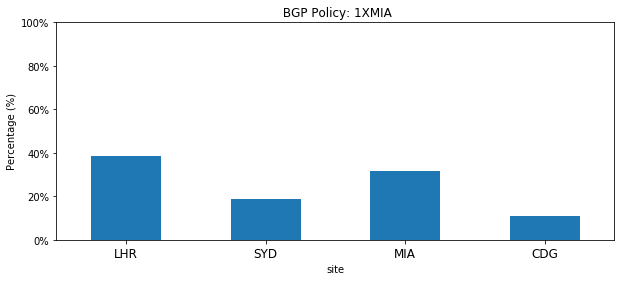

info for 2xMIA


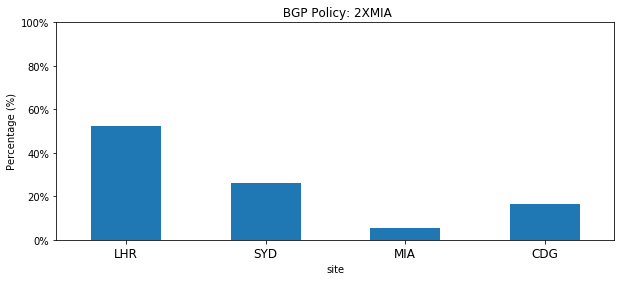

info for 3xMIA


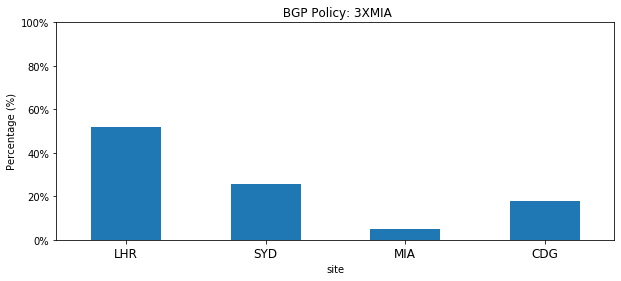

info for 4xMIA


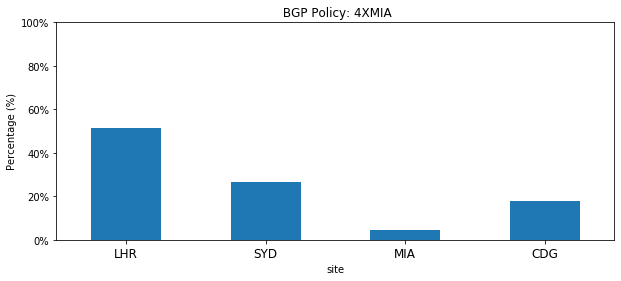

info for 5xMIA


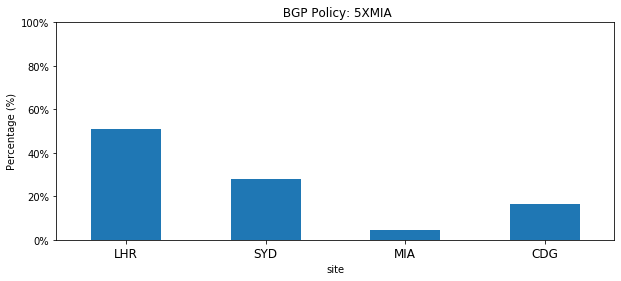

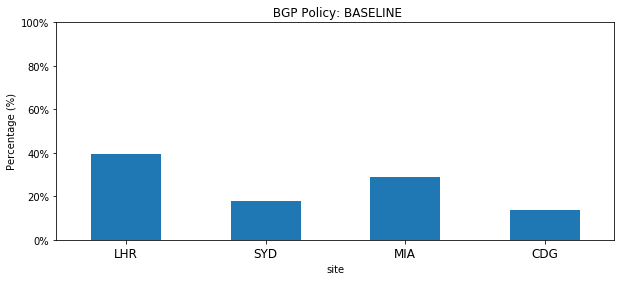

info for 1xLHR


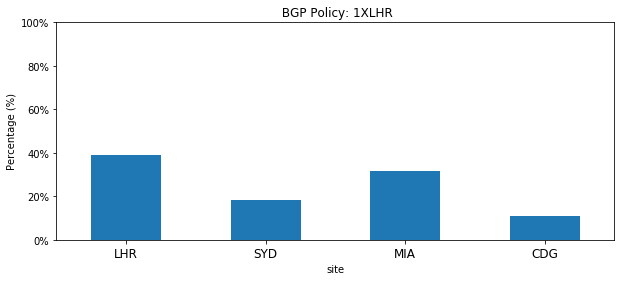

info for 2xLHR


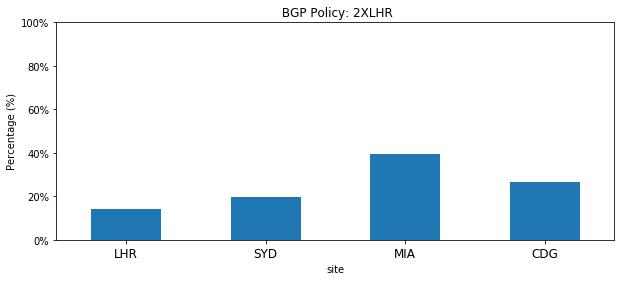

info for 3xLHR


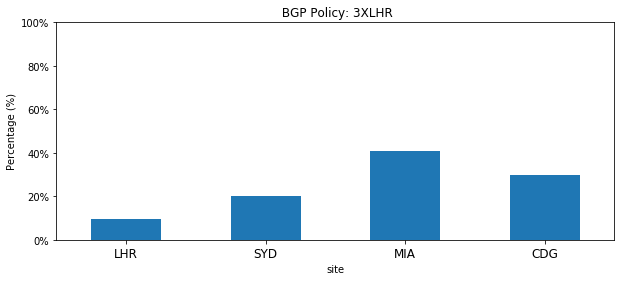

info for 4xLHR


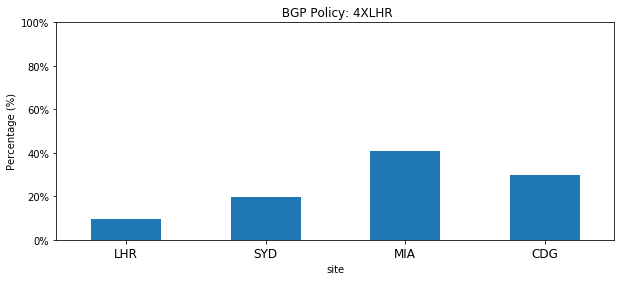

info for 5xLHR


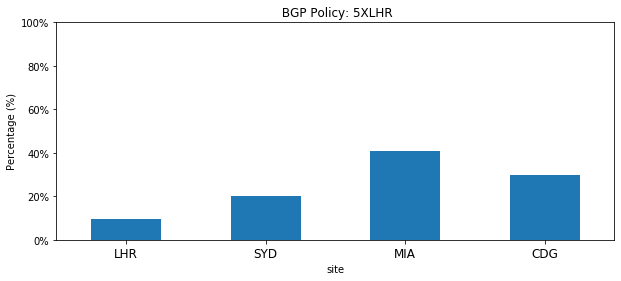

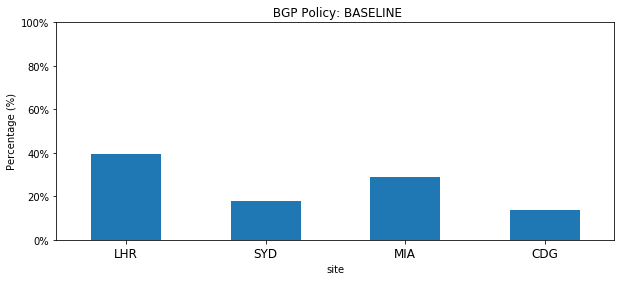

info for 1xCDG


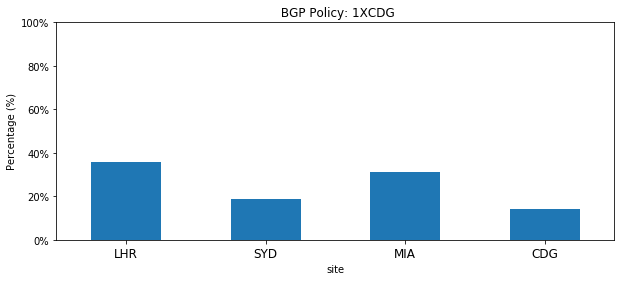

info for 2xCDG


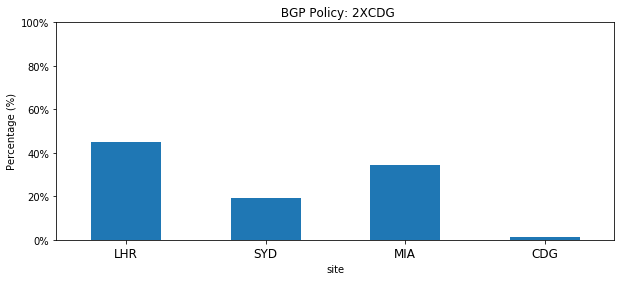

info for 3xCDG


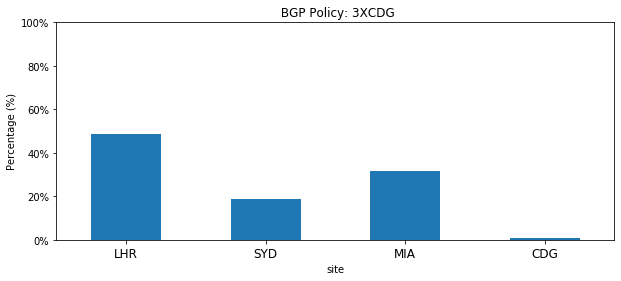

info for 4xCDG


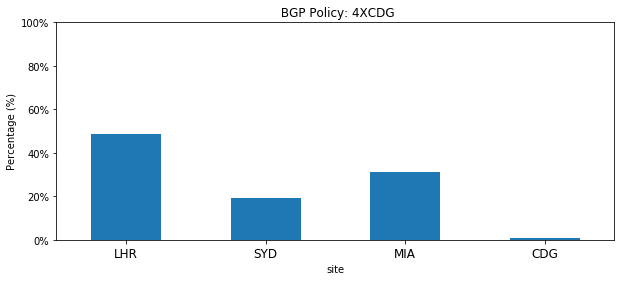

info for 5xCDG


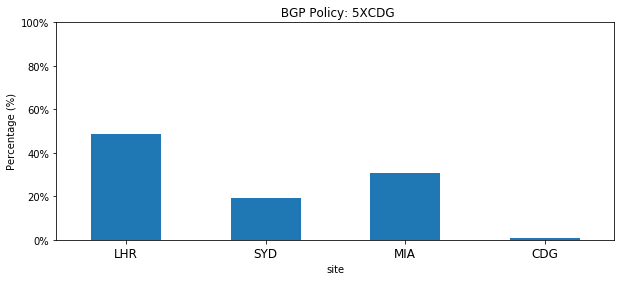

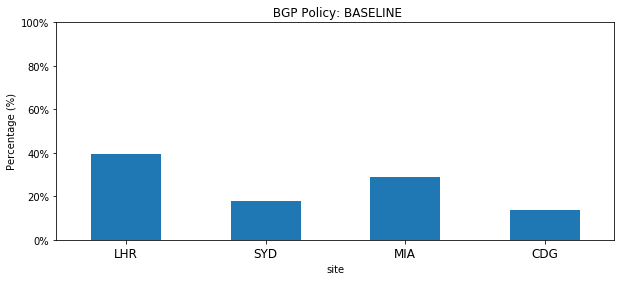

info for 1xSYD


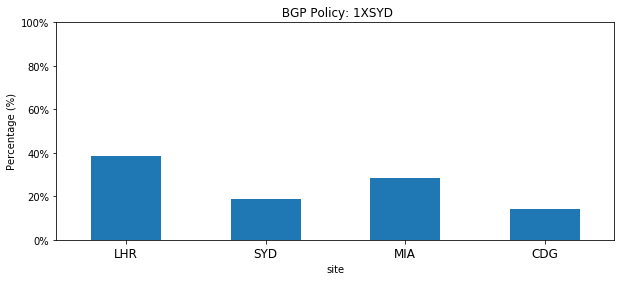

info for 2xSYD


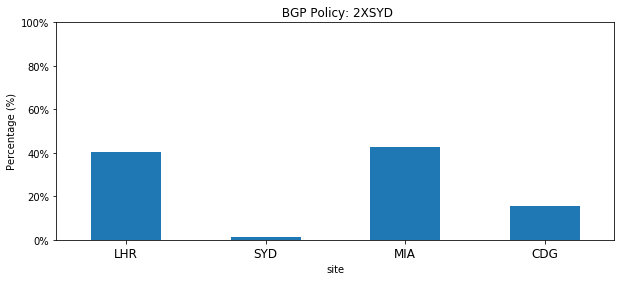

info for 3xSYD


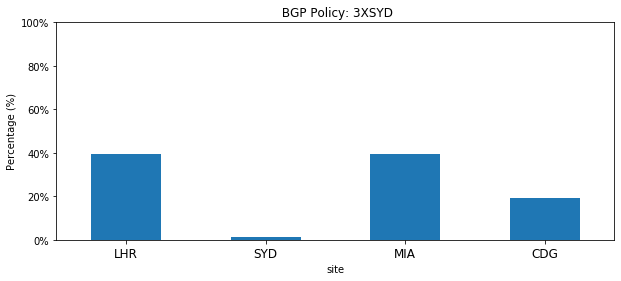

info for 4xSYD


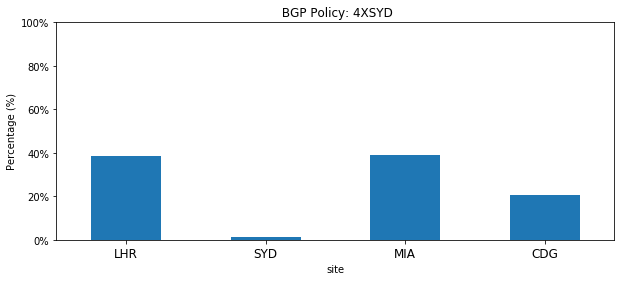

info for 5xSYD


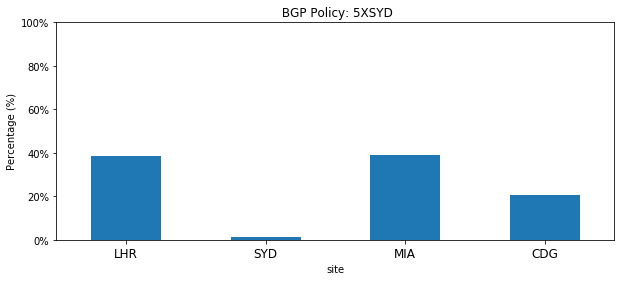

In [166]:
for site in sites:
    
    # plot graph contains the baseline
    title = "<h2 style=\"color:#069\" >Evaluating changes in: {} </h2>".format(site.upper())
    display(HTML(title))
    # plot baseline
    data = df_all[df_all['bgp'].str.contains("baseline")].set_index('site')
    label = data.loc[:,"bgp"][1]
    plot_site_bar(data,label,label+site)
    plt.show()
    
    for  policy in sorted(df_all[df_all['bgp'].str.contains(site)]['bgp'].unique().tolist()):

         print ("info for {}".format(policy))
        
         data = df_all[df_all['bgp'].str.contains(policy)].set_index('site')
         label = data.loc[:,"bgp"][1]
         plot_site_bar(data,label,policy)
                
         plt.show()
    display(HTML("<hr>"))


In [167]:
!cd imgs;convert -delay 15 -loop 0 baselineMIA.png 1xMIA.png 2xMIA.png 3xMIA.png MIA.gif; cd -

/bin/sh: line 0: cd: imgs: No such file or directory
convert: unable to open image 'baselineMIA.png': No such file or directory @ error/blob.c/OpenBlob/3497.
convert: unable to open image '1xMIA.png': No such file or directory @ error/blob.c/OpenBlob/3497.
convert: unable to open image '1xMIA.png': No such file or directory @ error/blob.c/OpenBlob/3497.
convert: unable to open image '2xMIA.png': No such file or directory @ error/blob.c/OpenBlob/3497.
convert: unable to open image '2xMIA.png': No such file or directory @ error/blob.c/OpenBlob/3497.
convert: unable to open image '3xMIA.png': No such file or directory @ error/blob.c/OpenBlob/3497.
convert: unable to open image '3xMIA.png': No such file or directory @ error/blob.c/OpenBlob/3497.
convert: no images defined `MIA.gif' @ error/convert.c/ConvertImageCommand/3273.
/bin/sh: line 0: cd: OLDPWD not set


In [168]:
!cd imgs;convert -delay 15 -loop 0  1xLHR.png 2xLHR.png 3xLHR.png 4xLHR.png 5xLHR.png LHR.gif; cd -

/bin/sh: line 0: cd: imgs: No such file or directory
convert: unable to open image '1xLHR.png': No such file or directory @ error/blob.c/OpenBlob/3497.
convert: unable to open image '2xLHR.png': No such file or directory @ error/blob.c/OpenBlob/3497.
convert: unable to open image '2xLHR.png': No such file or directory @ error/blob.c/OpenBlob/3497.
convert: unable to open image '3xLHR.png': No such file or directory @ error/blob.c/OpenBlob/3497.
convert: unable to open image '3xLHR.png': No such file or directory @ error/blob.c/OpenBlob/3497.
convert: unable to open image '4xLHR.png': No such file or directory @ error/blob.c/OpenBlob/3497.
convert: unable to open image '4xLHR.png': No such file or directory @ error/blob.c/OpenBlob/3497.
convert: unable to open image '5xLHR.png': No such file or directory @ error/blob.c/OpenBlob/3497.
convert: unable to open image '5xLHR.png': No such file or directory @ error/blob.c/OpenBlob/3497.
convert: no images defined `LHR.gif' @ error/convert.c/C

In [169]:
!cd imgs;convert -delay 10 -loop 0 baselineLHR.png 1xLHR.png 2xLHR.png 3xLHR.png LHR.gif; cd -

/bin/sh: line 0: cd: imgs: No such file or directory
convert: unable to open image 'baselineLHR.png': No such file or directory @ error/blob.c/OpenBlob/3497.
convert: unable to open image '1xLHR.png': No such file or directory @ error/blob.c/OpenBlob/3497.
convert: unable to open image '1xLHR.png': No such file or directory @ error/blob.c/OpenBlob/3497.
convert: unable to open image '2xLHR.png': No such file or directory @ error/blob.c/OpenBlob/3497.
convert: unable to open image '2xLHR.png': No such file or directory @ error/blob.c/OpenBlob/3497.
convert: unable to open image '3xLHR.png': No such file or directory @ error/blob.c/OpenBlob/3497.
convert: unable to open image '3xLHR.png': No such file or directory @ error/blob.c/OpenBlob/3497.
convert: no images defined `LHR.gif' @ error/convert.c/ConvertImageCommand/3273.
/bin/sh: line 0: cd: OLDPWD not set


In [170]:
!pwd

/Users/joaoceron/work/SAND/paper_bgp_catchment_manipulation/data_analysis/server_load


<hr>
<h1> Deviance from regular catchment distribution </h1>
<hr>

In [171]:
data = df_all.groupby(['site', 'bgp'])['percent'].sum()
data = data.unstack()
data

bgp       1xCDG      1xLHR      1xMIA      1xSYD      2xCDG      2xLHR  \
site                                                                     
CDG   14.274683  11.126059  11.135899  14.180886   1.297392  26.563278   
LHR   35.810110  38.815068  38.499419  38.554021  44.919471  14.083354   
MIA   31.299288  31.532640  31.811202  28.524542  34.458694  39.535023   
SYD   18.615919  18.526234  18.553480  18.740552  19.324442  19.818344   

bgp       2xMIA      2xSYD      3xCDG      3xLHR  ...      3xSYD      4xCDG  \
site                                              ...                         
CDG   16.237507  15.609391   0.980078  29.720334  ...  19.422147   0.965632   
LHR   52.109733  40.382570  48.575681   9.688790  ...  39.641719  48.449043   
MIA    5.379683  42.555757  31.529150  40.647415  ...  39.485563  31.388431   
SYD   26.273078   1.452281  18.915091  19.943461  ...   1.450570  19.196893   

bgp       4xLHR      4xMIA      4xSYD      5xCDG      5xLHR      5xMIA  \
site                                                                     
CDG   30.021939  17.822679  20.804424   0.901164  29.834297  16.627478   
LHR    9.429421  51.292805  38.601614  48.833540   9.425587  51.135216   
MIA   40.838053   4.459663  39.143272  30.843570  40.672346   4.343089   
SYD   19.710587  26.424852   1.450691  19.421726  20.067770  27.894217   

bgp       5xSYD   baseline  
site                        
CDG   20.825918  13.859484  
LHR   38.672320  39.374557  
MIA   39.044925  28.726370  
SYD    1.456837  18.039589  

[4 rows x 21 columns]

In [172]:
# data.index.get_level_values(2)
# df_all# type(data)

df2 = pd.DataFrame()
for index in data.index.tolist():
    data.loc[index,:]
    df = data.loc[index,:].reset_index()
    # get value reference
    reference_value = df[df.bgp=="baseline"].iloc[0,1]
    
    # new column  
    column = "diff_"+index
    df[column] =   reference_value - df[index] 
    df=df[~df.bgp.str.contains('baseline')]
    df.drop(index, axis=1,inplace=True)
    df2 = pd.concat([df, df2],sort=False)
df_diff = df2.groupby('bgp').sum().reset_index().set_index('bgp')

In [173]:
df_diff

diff_SYD   diff_MIA   diff_LHR   diff_CDG
bgp                                              
1xCDG  -0.576330  -2.572918   3.564447  -0.415199
1xLHR  -0.486644  -2.806270   0.559490   2.733425
1xMIA  -0.513890  -3.084832   0.875138   2.723585
1xSYD  -0.700962   0.201828   0.820537  -0.321403
2xCDG  -1.284853  -5.732324  -5.544914  12.562091
2xLHR  -1.778755 -10.808653  25.291203 -12.703795
2xMIA  -8.233489  23.346687 -12.735175  -2.378023
2xSYD  16.587308 -13.829387  -1.008013  -1.749908
3xCDG  -0.875501  -2.802780  -9.201123  12.879405
3xLHR  -1.903871 -11.921045  29.685767 -15.860851
3xMIA  -7.634053  23.977607 -12.503422  -3.840132
3xSYD  16.589019 -10.759194  -0.267162  -5.562664
4xCDG  -1.157304  -2.662062  -9.074486  12.893851
4xLHR  -1.670998 -12.111683  29.945136 -16.162455
4xMIA  -8.385263  24.266706 -11.918247  -3.963196
4xSYD  16.588898 -10.416902   0.772944  -6.944940
5xCDG  -1.382137  -2.117200  -9.458983  12.958320
5xLHR  -2.028180 -11.945977  29.948970 -15.974813
5xMIA  -9.854628  24.383280 -11.760658  -2.767994
5xSYD  16.582752 -10.318555   0.702237  -6.966434

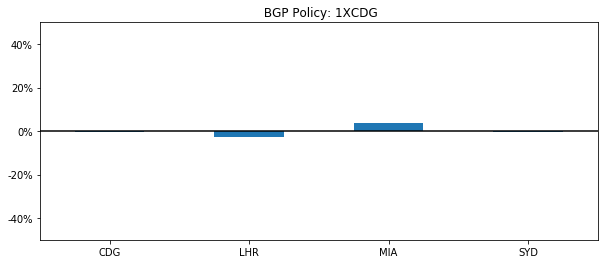

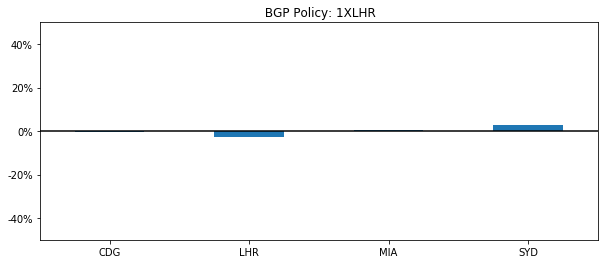

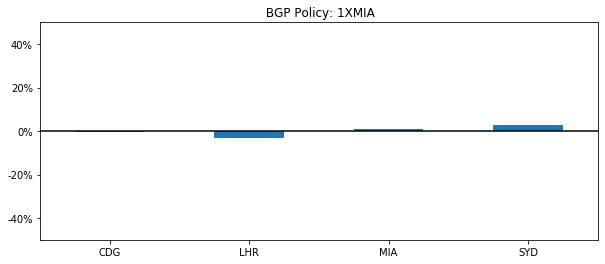

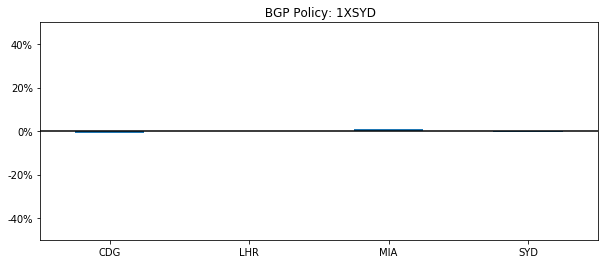

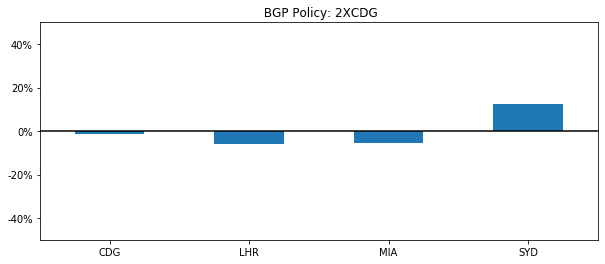

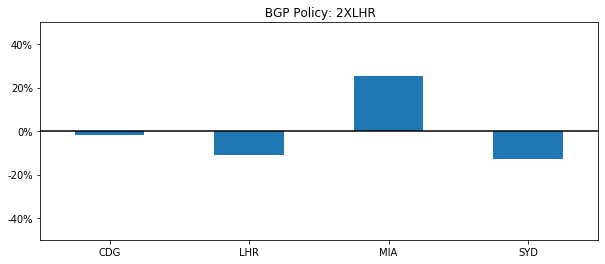

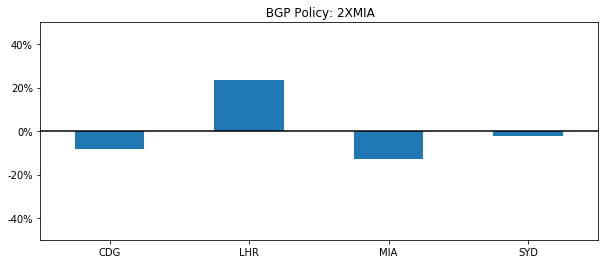

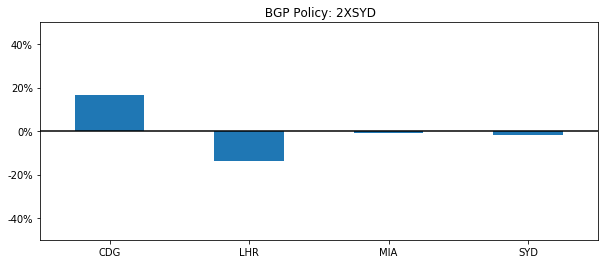

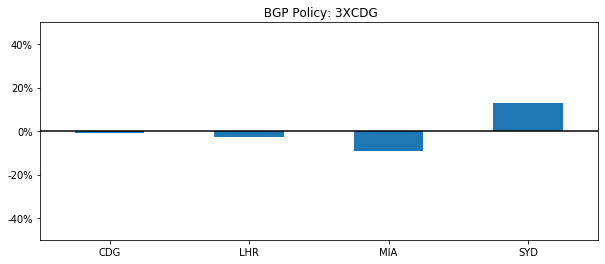

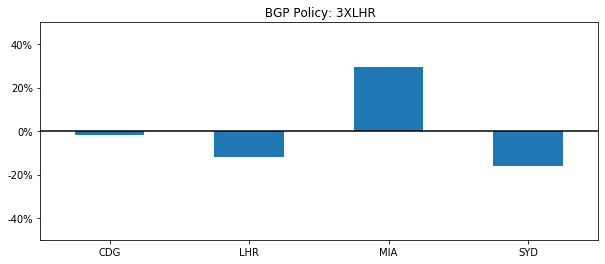

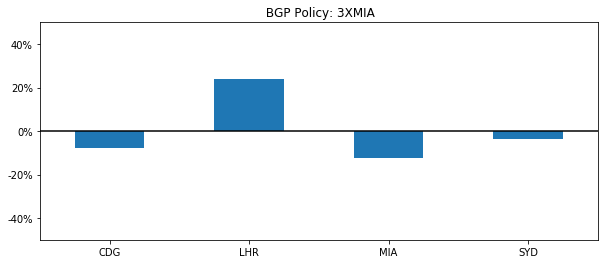

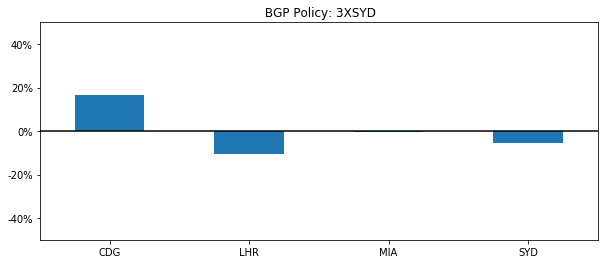

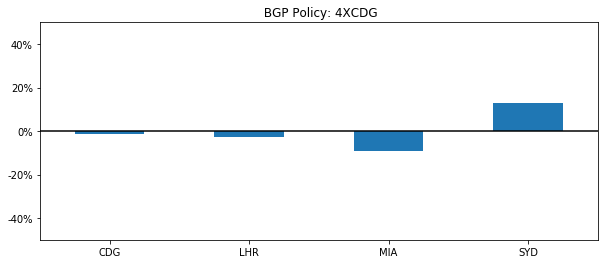

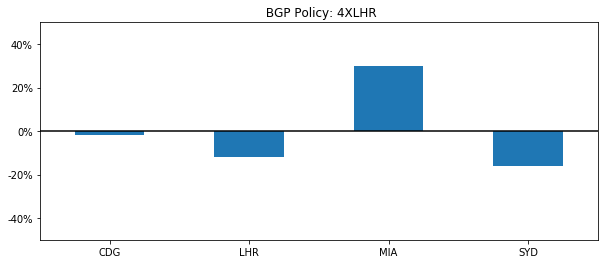

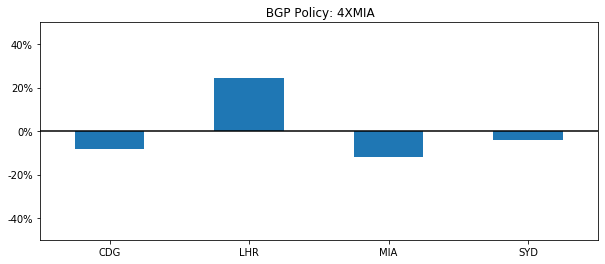

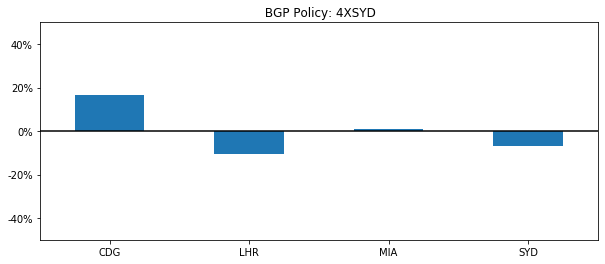

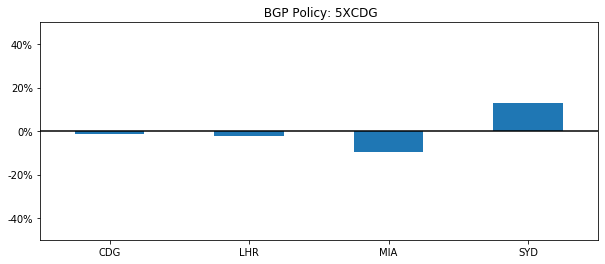

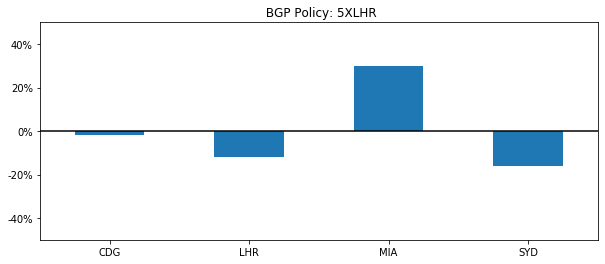

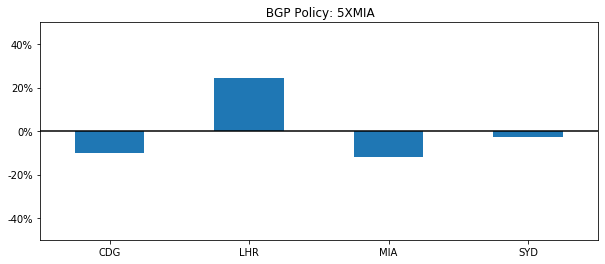

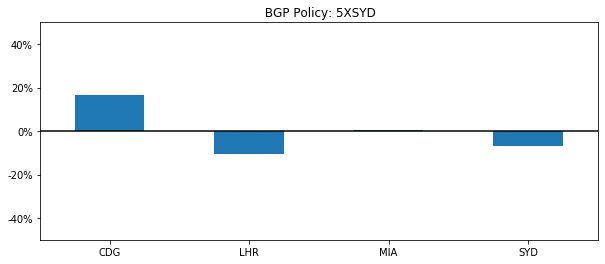

In [174]:
for index in df_diff.index.tolist():
    fig = plt.figure(figsize=(10, 4))
    ax = plt.subplot2grid((1,1), (0,0))
    ax.axhline(y=0, xmin=-1, xmax=1.0, color='black')

    g=df_diff.loc[index,:].plot(kind="bar",ax=ax)
    title = ' BGP Policy: {}'.format(index.upper())
    ax.set_title(title)
    
    xlabels = data.index.get_level_values(0).tolist()
    ax.set_xticklabels(xlabels, rotation=0);
    ax.set_ylim(ymin=-50, ymax=50);

    plt.gca().set_yticklabels(['{:.0f}%'.format(x*1) for x in plt.gca().get_yticks()]) 

    xlabels = data.index.get_level_values(0).tolist()
    ax.set_xticklabels(xlabels, rotation=0);
    figure_name = index+"_diff"
#     fig.savefig("./imgs/"+figure_name+".png", bbox_inches='tight', dpi=1200)

#     plt.show()

---
---
<h1 align="center"> Catchment SIDE EFFECT </h1>

---
---

In [175]:
import plotly.graph_objs as go
import chart_studio.plotly as py
import plotly 

from plotly import exceptions
import plotly.figure_factory as ff
 

# py.offline.init_notebook_mode(connected=True)
# py.tools.set_config_file(world_readable=False, sharing='private')

In [176]:
# bgp_list = ['1xCDG','2xCDG','3xCDG','4xCDG','5xCDG', '1xLHR','2xLHR','3xLHR','4xLHR','5xLHR','1xMIA','2xSYD',
#  '3xMIA','4xMIA','5xMIA','6xMIA','7xMIA','8xMIA', '1xSYD','2xSYD','3xSYD','4xSYD','5xSYD','6xSYD',
#  '7xSYD','8xSYD', 'baseline']
# bgp_list


In [159]:
df = df_all
layout = go.Layout(
    barmode='overlay',
    title='.:Tangled Testbed:.Site Load Distrution',
    showlegend=True, 
    xaxis = dict(
        tickangle=0
    ),
        
    # y axis
    yaxis = dict(
     fixedrange = True,
     range = [0,100],
     title = "nets (%)",
     ticksuffix = "%",
    ),   
)

data_slider = []
# bgp_list = ['baseline',]
# bgp_list = df['bgp'].unique().tolist()
# bgp_list.sort()

# bgp_list = ['baseline', '1xSYD', '2xSYD', '3xSYD', '1xCDG', '2xCDG', '3xCDG', '1xLHR', '2xLHR', '3xLHR', '1xMIA', '2xMIA', '3xMIA']
# for bgp in df['bgp'].unique():    
# bgp_list=bgp_list.reverse()
bgp_list = ['1xCDG','2xCDG','3xCDG','4xCDG','5xCDG', '1xLHR','2xLHR','3xLHR','4xLHR','5xLHR','1xMIA','2xSYD',
 '3xMIA','4xMIA','5xMIA','6xMIA','7xMIA','8xMIA', '1xSYD','2xSYD','3xSYD','4xSYD','5xSYD','6xSYD',
 '7xSYD','8xSYD', 'baseline']
# for bgp in bgp_list:
for bgp in df['bgp'].unique():    

#     print (bgp)
    df_bgp_policy = df[(df['bgp']== bgp)]    
    df_bgp_policy.sort_values(by=['site'],inplace=True)
    # array of graphics - for each BGP policy
    data_each_policy = dict(
                        type='bar',
                        visible=False,
                        x=df_bgp_policy['site'],
                        y=df_bgp_policy['percent'].astype(int),
                        showlegend=False,
                        hovertext="",
                        marker=dict(color="mediumseagreen"),
                        hoverinfo = "y",
                        customdata = (bgp,),
                        )
    

    
    # array of graphs
    data_slider.append(data_each_policy)

data_slider[1]['visible']=True
steps = []


for i in range(len(data_slider)):
    label = data_slider[i]['customdata'][0]
    step = dict(method='restyle',
                args=['visible', [False] * len(data_slider)],
                label='{}'.format(label)
               )
    step['args'][1][i] = True
    steps.append(step)

sliders = [dict(active=1, pad={"t": 30}, steps=steps)]
layout[ 'sliders' ] = sliders
# layout[ 'annotations' ] = annot
fig = go.Figure()
fig = dict(data=data_slider, layout=layout)

plotly.offline.iplot(fig)



NameError: name 'go' is not defined

---
---
<h1 align="center"> SITE LOAD (/24)</h1>

---
---

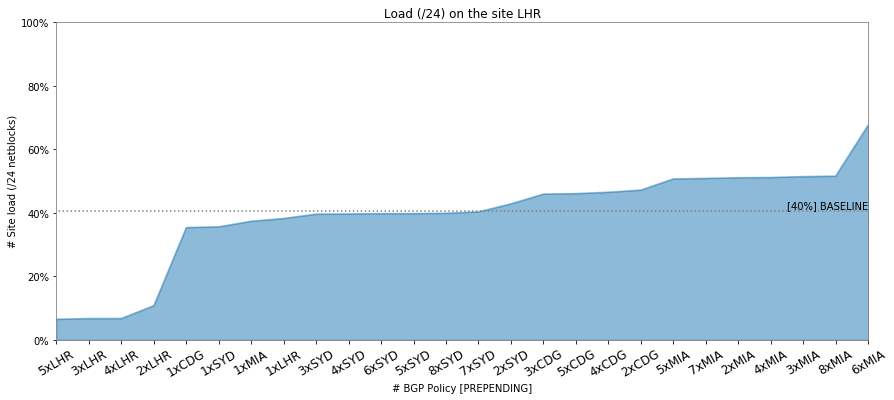

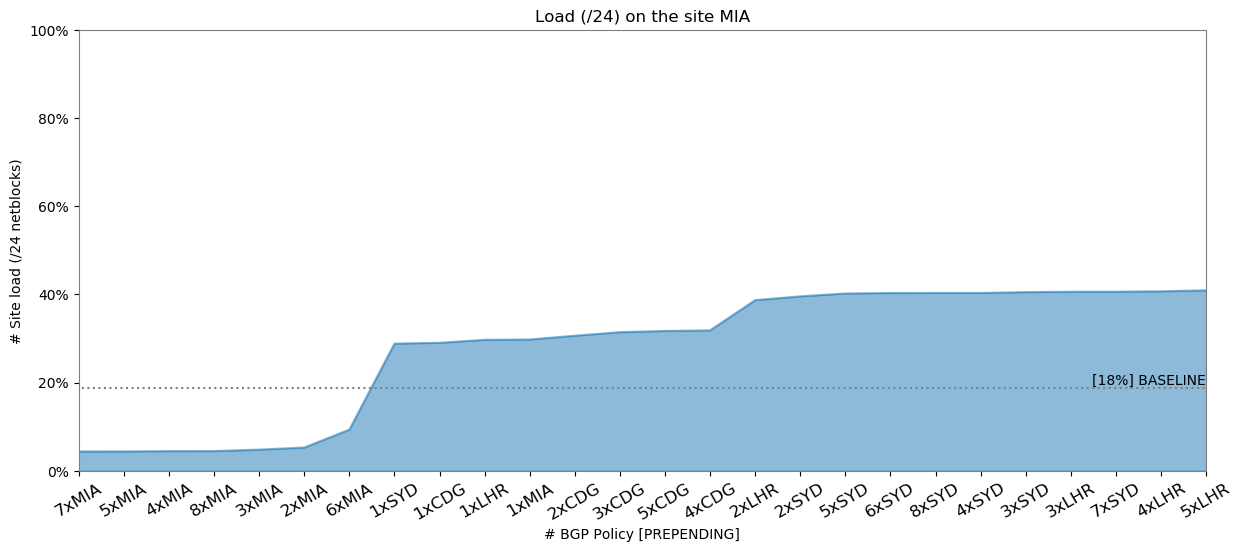

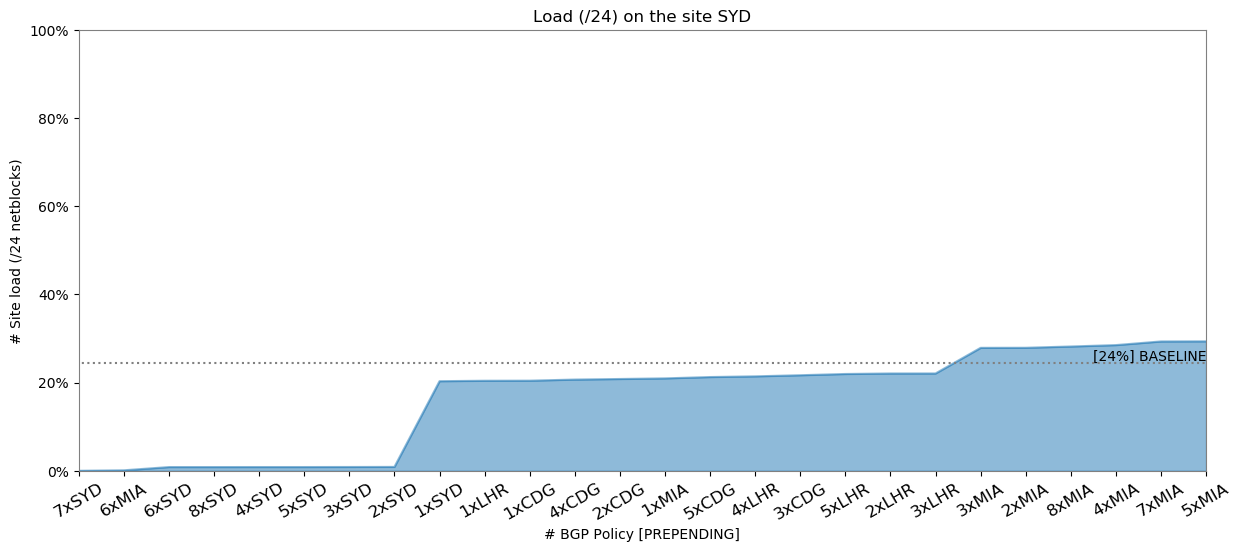

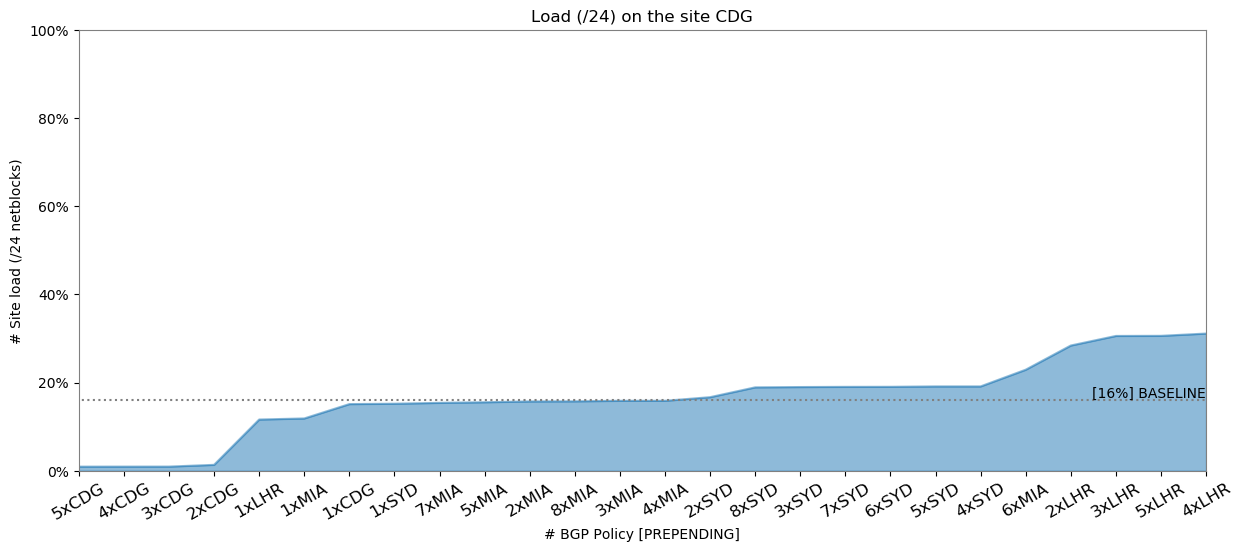

In [31]:
df = df_all

for site in df.site.unique():

    (fig,ax) = init_fig()
    title = "<h2 style=\"color:#069\" >SITE: {} </h2>".format(site.upper())
    display(HTML(title))
    
    df_site = df[df['site']==site].sort_values(by="bgp")
    df_site=df_site[~df_site.bgp.str.contains('baseline')]
    data = df_site[["percent","bgp"]] 
    data.set_index('bgp',inplace=True)
    data = data.sort_values('percent')
    
    data.plot(ax=ax, kind='area',stacked=False);

    
    title = 'Load (/24) on the site {}'.format(site.upper())
    ax.set_title(title);
    ax.set_ylim(ymax=100, ymin=0);
    plt.gca().set_yticklabels(['{:.0f}%'.format(x*1) for x in plt.gca().get_yticks()]) 
    ax.get_legend().remove()
    

    # REFERENCE LINE
    get_and_plot_reference_value(df,site)
    
    # xlabel
    ax.set_xlabel('# BGP Policy [PREPENDING]');
    ax.set_ylabel('# Site load (/24 netblocks)');

    xlabels = data.index.get_level_values(0).tolist()
    ax.xaxis.set_tick_params(labelsize=12)
    ax.xaxis.label.set_color('black')
    plt.xticks(np.arange(len(data)), xlabels, rotation=30)
    
    plt.show()

33.18966094456776


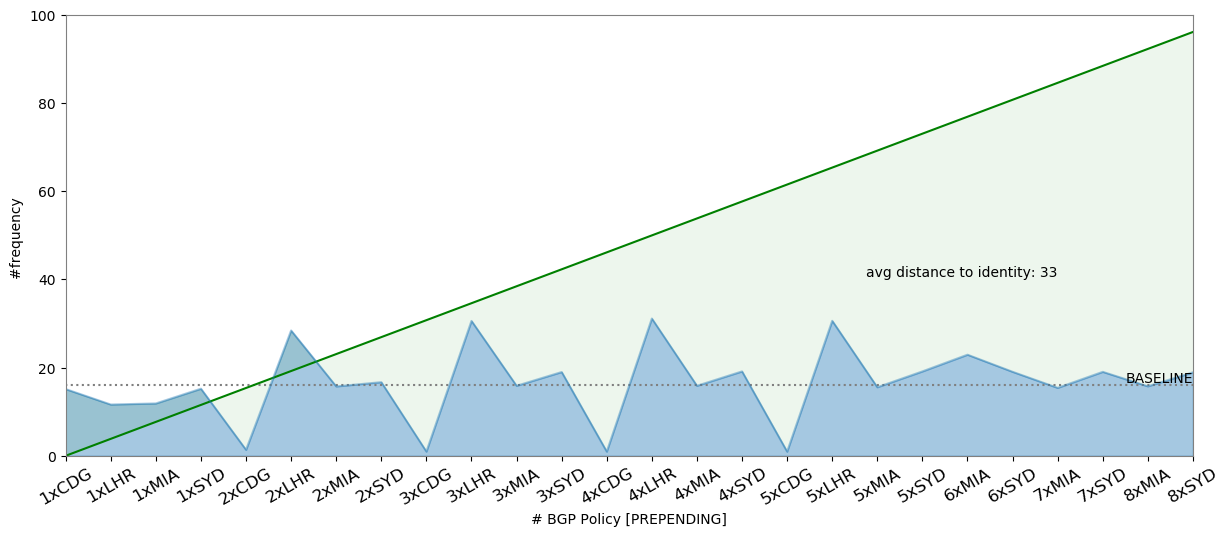

In [32]:
df = df_all

df_site = df[df['site']=="CDG"].sort_values(by="bgp")



(fig,ax) = init_fig()
title = "<h2 style=\"color:#069\" >SITE: {} </h2>".format(site.upper())
display(HTML(title))

df_site = df[df['site']==site].sort_values(by="bgp")
reference_value = df_site[df_site.bgp=="baseline"].iloc[0,2]
df_site=df_site[~df_site.bgp.str.contains('baseline')]
ax.axhline(y=reference_value, xmin=-1, xmax=1.0, color='grey', linestyle='dotted')
#     ax.axhline(y=8.5, color='grey',linestyle='dotted')

data = df_site[["percent","bgp"]] 

data.set_index('bgp',inplace=True)

# data = data.sort_values(by="percent")
data.reset_index().head()

# identify function
number_of_groups = 100/int(data.size)
identity = pynum_float.arange(0, 100,number_of_groups)
data['identity'] = identity
data['distance'] = (data['identity'] - data['percent']).clip(lower=0)
print (data['distance'].mean())

# (fig,ax) = init_fig()

# data['distance'].plot(ax=ax,
#           kind='bar',
#          )
data['identity'].plot(ax=ax,
          kind='line',
          color='green',
                      stacked=False,
                     )
data['percent'].plot(ax=ax,
          kind='area',
                    alpha=.4)
                    
# data['distance'].plot(ax=ax,
#           kind='bar',
#                       stacked=False)

# leg = ax.legend();
ax.set_ylim(ymax=100);
ax.set_xlim(xmin=0);
# xlabel
ax.set_xlabel('# BGP Policy [PREPENDING]');
ax.set_ylabel('# Site load (/24 netblocks)');

xlabels = data.index.get_level_values(0).tolist()
ax.xaxis.set_tick_params(labelsize=12)
ax.xaxis.label.set_color('black')
plt.xticks(np.arange(len(data)), xlabels, rotation=30)
    
# ax.get_legend().remove()
ax.annotate("BASELINE",
             xy=(25, reference_value),
             ha='right',
             color='black',
             va='bottom')

msg = "avg distance to identity: {}".format(int(data['distance'].mean()))
ax.annotate(msg,
             xy=(22, 40),
             ha='right',
             color='black',
             va='bottom')

plt.fill_between(data.index, data.percent, data.identity, alpha=.07, facecolor='green')

# ax.axvline(x=1,  color='grey')
# ax.axvline(x=1, color='grey')


# -------
degrees_of_control = 10
bins = list (range(0,100,degrees_of_control))
data['binned'] = pd.cut(data['percent'], bins)

# xlabel
label = '#frequency '.format(degrees_of_control)
ax.set_ylabel(label);


# all xlabels
all_markers = data.index.to_list()

# xlabel where we detect a change in the behaviour
first = data.drop_duplicates('binned', keep="first") 
last = data.drop_duplicates('binned', keep="last") 
markers = pd.concat([first,last]).reset_index()['bgp'].to_list()
markers

for xlabel in  markers: 
#     print (xlabel)
    index = all_markers.index(xlabel)
#     print (index)
#     ax.axvline(x=index, color='grey',linewidth=0.21)
plt.show()
# ax.fill_betweenx(1,1, interpolate=True)



---
---
<h1 align="center"> John's graphic </h1>

---
---

In [33]:
df = df_all
df_all

site    count    percent    bgp
0   LHR  1696223  47.157127  2xCDG
1   MIA  1102886  30.661614  2xCDG
2   SYD   749233  20.829617  2xCDG
3   CDG    48618   1.351641  2xCDG
0   LHR  1843011  50.667415  5xMIA
..  ...      ...        ...    ...
3   SYD    30786   0.849313  8xSYD
0   LHR  1664244  46.047522  5xCDG
1   MIA  1147006  31.736202  5xCDG
2   SYD   768800  21.271721  5xCDG
3   CDG    34138   0.944555  5xCDG

[108 rows x 4 columns]

16.03871923591512


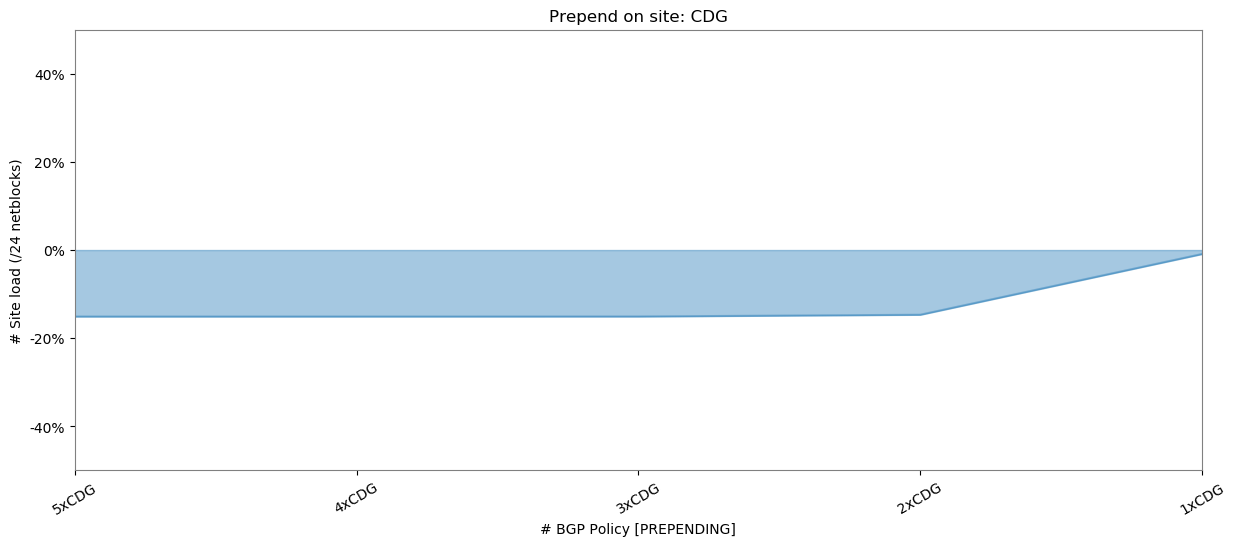

In [34]:
df = df_all
# prepend="MIA"
site = "CDG"
prepend=site

# select the node
df_site = df[df['site']==site].sort_values(by="bgp", ascending=True)

# select the site
# df_site = df_site[df_site.bgp.str.contains(prepend+"|MIA")]
df_site = df_site[df_site.bgp.str.contains(prepend)]

reference_value = df[(df.bgp=="baseline") & (df.site==site)].iloc[0,2]

data = df_site[["percent","bgp"]].sort_values(by="bgp", ascending=False)
data.set_index('bgp',inplace=True)
data.head()

data = pd.concat([data,data.head(1)]).drop_duplicates('percent', keep="last")
print (reference_value)
data['diff'] = data['percent'] - reference_value
data = data.sort_values(by="bgp", ascending=False)
# data= data.reindex(['8xMIA', '7xMIA', '6xMIA', '1xCDG', '5xMIA', '5xCDG', '4xMIA', '4xCDG', '3xMIA',
#        '3xCDG', '2xMIA', '2xCDG', '1xMIA'])
 
data.index.tolist()

(fig,ax) = init_fig()

# fig = plt.figure(figsize=(10, 2))
# fig,axes = plt.subplots(nrows=2, ncols=2)
# ax=axes[0,0]
# ax = plt.subplot2grid((1,1), (0,0))
# axes = plt.subplots(1, 2)
# fig, axes = plt.subplots(1, 2)

# data= data.reindex(['8xMIA',
#  '7xMIA',
#  '6xMIA',
#  '5xMIA',
#  '4xMIA',
#  '3xMIA',
#  '2xMIA',
#  '1xMIA',             
#  '5xCDG',            
#  '4xCDG',
#  '3xCDG',
#  '2xCDG',
#  '1xCDG',
# ])

data['diff'].plot(ax=ax,kind='area', stacked=False, alpha=.4)
ax.set_ylim(ymax=50,ymin=-50);
ax.set_xlim(xmin=0);
ax.set_xlabel('# BGP Policy [PREPENDING]');
ax.set_ylabel('# Site load (/24 netblocks)');
ax.set_title("Prepend on site: {}".format(site));
# Xticks
xlabels = data.index.get_level_values(0).tolist()
ax.xaxis.set_tick_params(labelsize=10)
# ax.set_ylim(ymax=100);
# ax.set_xlim(xmin=0);
plt.xticks(np.arange(len(data)), xlabels, rotation=30)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*1) for x in plt.gca().get_yticks()]);




LHR
40.70225827288564
MIA
18.868886848158144
SYD
24.390135643041088
CDG
16.03871923591512


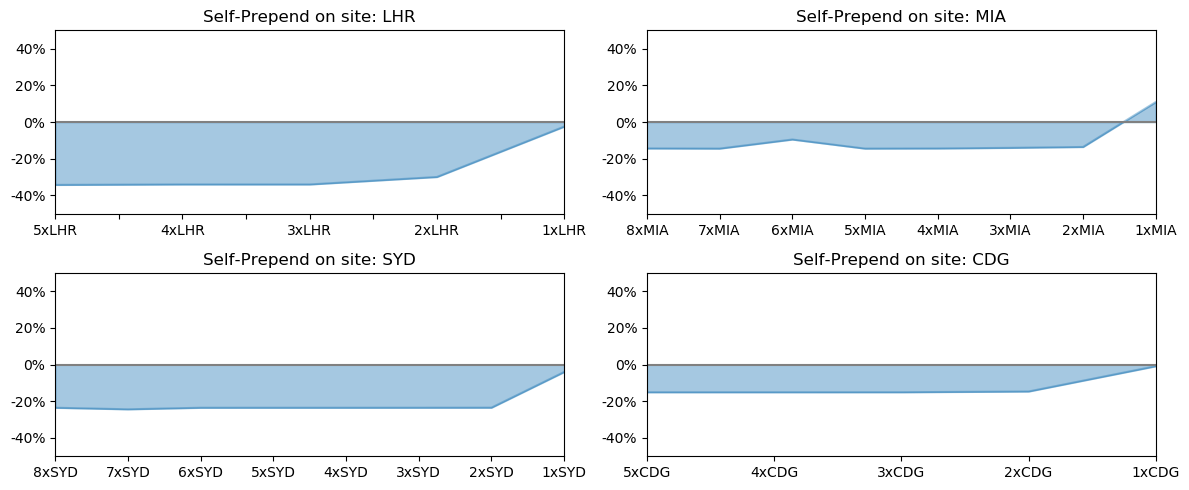

In [35]:
fig = plt.figure(constrained_layout=False, figsize=(12, 5))
grid4 = fig.add_gridspec(ncols=2, nrows=2)
ax1 = fig.add_subplot(grid4[0, 0])
ax2 = fig.add_subplot(grid4[0, 1])
ax3 = fig.add_subplot(grid4[1, 0])
ax4 = fig.add_subplot(grid4[1, 1])

df = df_all
count = 0
for site in df.site.unique()[0:4]:
    count+=1
    print (site)
    prepend = site

    # select the node
    df_site = df[df['site']==site].sort_values(by="bgp", ascending=True)
    # bgp policies
    df_site = df_site[df_site.bgp.str.contains(prepend)]

    reference_value = df[(df.bgp=="baseline") & (df.site==site)].iloc[0,2]
    data = df_site[["percent","bgp"]].sort_values(by="bgp", ascending=False)
    data.set_index('bgp',inplace=True)
    data = pd.concat([data,data.head(1)]).drop_duplicates('percent', keep="last")
    print (reference_value)
    data['diff'] = data['percent'] - reference_value
    data = data.sort_values(by="bgp", ascending=False)
    
    if (count == 1):
        data['diff'].plot(ax=ax1,kind='area', stacked=False, alpha=.4)
        ax1.set_ylim(ymax=50,ymin=-50);
#         ax.set_xlabel('# BGP Policy [PREPENDING]');
# ax.set_ylabel('# Site load (/24 netblocks)');
# ax.set_title("Prepend on site: {}".format(site));
# Xticks
        xlabels = data.index.get_level_values(0).tolist()
        ax1.xaxis.set_tick_params(labelsize=10)
        plt.xticks(np.arange(len(data)), xlabels, rotation=30)
        ax1.set_xlabel('');
        vals = ax1.get_yticks()
        ax1.set_yticklabels(['{:.0f}%'.format(x) for x in vals])
        ax1.axhline(y=0, xmin=-1, xmax=1.0, color='grey')
        ax1.set_title("Self-Prepend on site: {}".format(site));

        
    if (count == 2):
        data['diff'].plot(ax=ax2,kind='area', stacked=False, alpha=.4)
        ax2.set_ylim(ymax=50,ymin=-50);
        ax2.set_xlabel('');
        vals = ax2.get_yticks()
        ax2.set_yticklabels(['{:.0f}%'.format(x) for x in vals])
#         ax2.annotate("BASELINE",xy=(7, 0), ha='right',color='black',va='bottom')
        ax2.axhline(y=0, xmin=-1, xmax=1.0, color='grey')
        ax2.set_title("Self-Prepend on site: {}".format(site));

    if (count == 3):
        data['diff'].plot(ax=ax3,kind='area', stacked=False, alpha=.4)
        ax3.set_ylim(ymax=50,ymin=-50);
        ax3.set_xlabel('');
        vals = ax3.get_yticks()
        ax3.set_yticklabels(['{:.0f}%'.format(x) for x in vals])
        ax3.axhline(y=0, xmin=-1, xmax=1.0, color='grey')
        ax3.set_title("Self-Prepend on site: {}".format(site));

    if (count == 4):
        data['diff'].plot(ax=ax4,kind='area', stacked=False, alpha=.4)
        ax4.set_ylim(ymax=50,ymin=-50);
        ax4.set_xlabel('');
        vals = ax4.get_yticks()
        ax4.set_yticklabels(['{:.0f}%'.format(x) for x in vals])
        ax4.axhline(y=0, xmin=-1, xmax=1.0, color='grey')
        ax4.set_title("Self-Prepend on site: {}".format(site)); 
        
plt.tight_layout()
 


## Version 2

/Users/joaoceron/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3489: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


CDG
            loc_prepend    percent
num_prepend                       
 0                  CDG  13.859484
-1                  CDG  14.274683
-2                  CDG   1.297392
-3                  CDG   0.980078
-4                  CDG   0.965632
-5                  CDG   0.901164
            loc_prepend    percent
num_prepend                       
0                   LHR  39.374557
1                   LHR  11.126059
2                   LHR  26.563278
3                   LHR  29.720334
4                   LHR  30.021939
5                   LHR  29.834297
            loc_prepend    percent
num_prepend                       
0                   MIA  28.726370
1                   MIA  11.135899
2                   MIA  16.237507
3                   MIA  17.699616
4                   MIA  17.822679
5                   MIA  16.627478
            loc_prepend    percent
num_prepend                       
0                   SYD  18.039589
1                   SYD  14.180886
2               

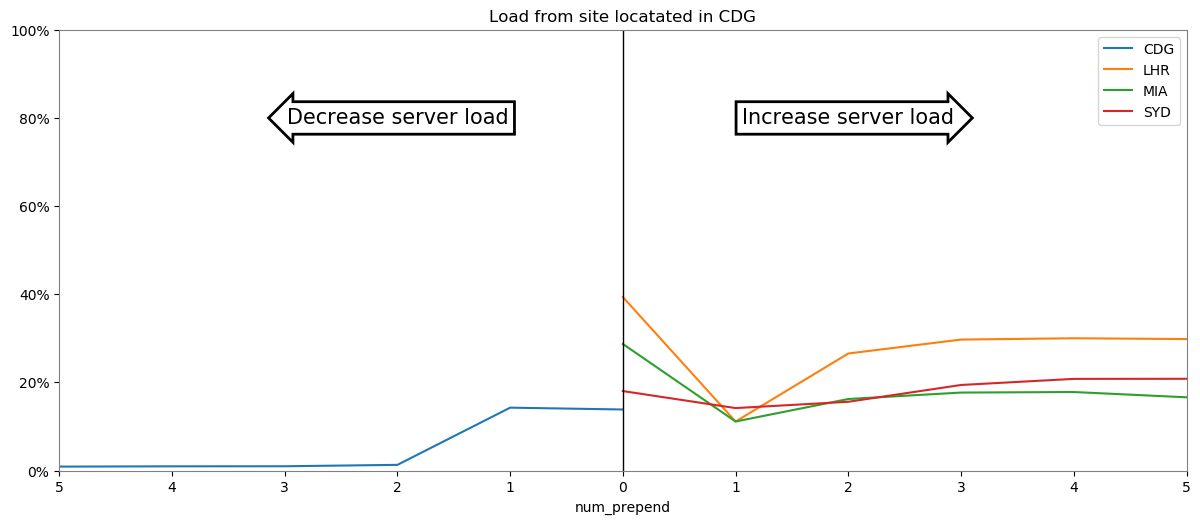

LHR
            loc_prepend    percent
num_prepend                       
0                   CDG  13.859484
1                   CDG  35.810110
2                   CDG  44.919471
3                   CDG  48.575681
4                   CDG  48.449043
5                   CDG  48.833540
            loc_prepend    percent
num_prepend                       
 0                  LHR  39.374557
-1                  LHR  38.815068
-2                  LHR  14.083354
-3                  LHR   9.688790
-4                  LHR   9.429421
-5                  LHR   9.425587
            loc_prepend    percent
num_prepend                       
0                   MIA  28.726370
1                   MIA  38.499419
2                   MIA  52.109733
3                   MIA  51.877979
4                   MIA  51.292805
5                   MIA  51.135216
            loc_prepend    percent
num_prepend                       
0                   SYD  18.039589
1                   SYD  38.554021
2               

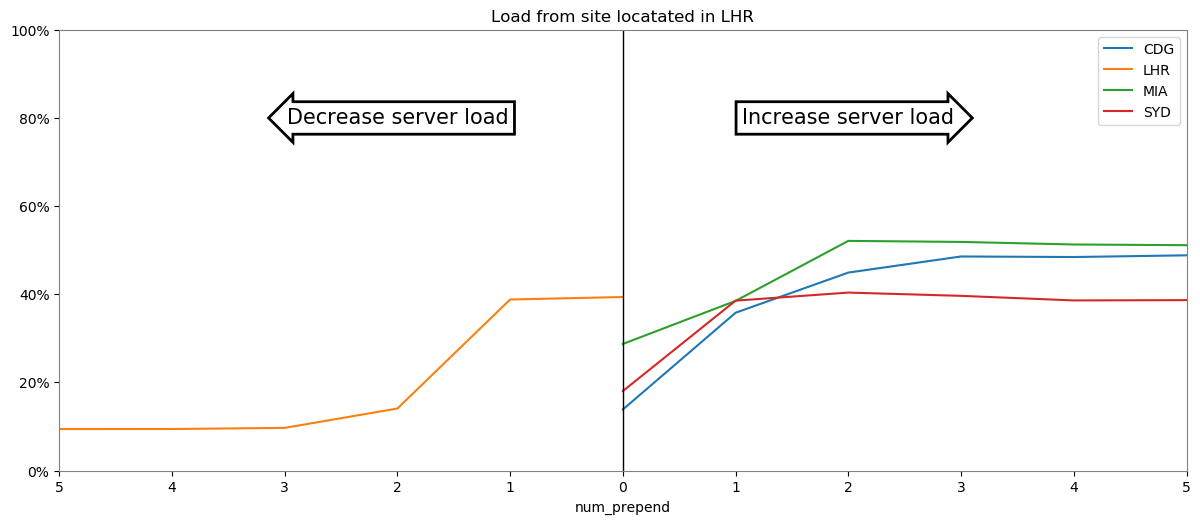

MIA
            loc_prepend    percent
num_prepend                       
0                   CDG  13.859484
1                   CDG  31.299288
2                   CDG  34.458694
3                   CDG  31.529150
4                   CDG  31.388431
5                   CDG  30.843570
            loc_prepend    percent
num_prepend                       
0                   LHR  39.374557
1                   LHR  31.532640
2                   LHR  39.535023
3                   LHR  40.647415
4                   LHR  40.838053
5                   LHR  40.672346
            loc_prepend    percent
num_prepend                       
 0                  MIA  28.726370
-1                  MIA  31.811202
-2                  MIA   5.379683
-3                  MIA   4.748763
-4                  MIA   4.459663
-5                  MIA   4.343089
            loc_prepend    percent
num_prepend                       
0                   SYD  18.039589
1                   SYD  28.524542
2               

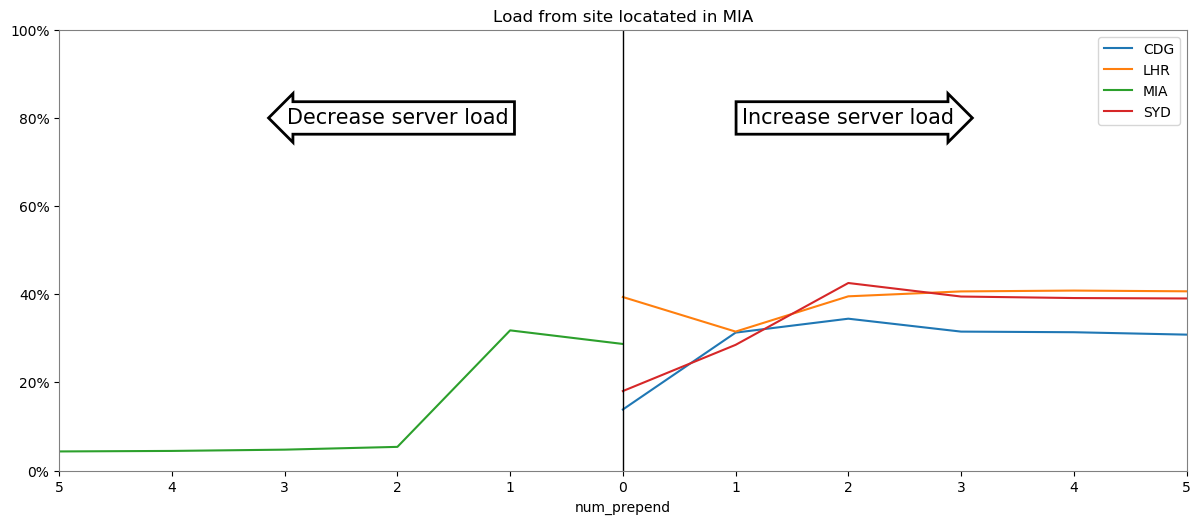

SYD
            loc_prepend    percent
num_prepend                       
0                   CDG  13.859484
1                   CDG  18.615919
2                   CDG  19.324442
3                   CDG  18.915091
4                   CDG  19.196893
5                   CDG  19.421726
            loc_prepend    percent
num_prepend                       
0                   LHR  39.374557
1                   LHR  18.526234
2                   LHR  19.818344
3                   LHR  19.943461
4                   LHR  19.710587
5                   LHR  20.067770
            loc_prepend    percent
num_prepend                       
0                   MIA  28.726370
1                   MIA  18.553480
2                   MIA  26.273078
3                   MIA  25.673642
4                   MIA  26.424852
5                   MIA  27.894217
            loc_prepend    percent
num_prepend                       
 0                  SYD  18.039589
-1                  SYD  18.740552
-2              

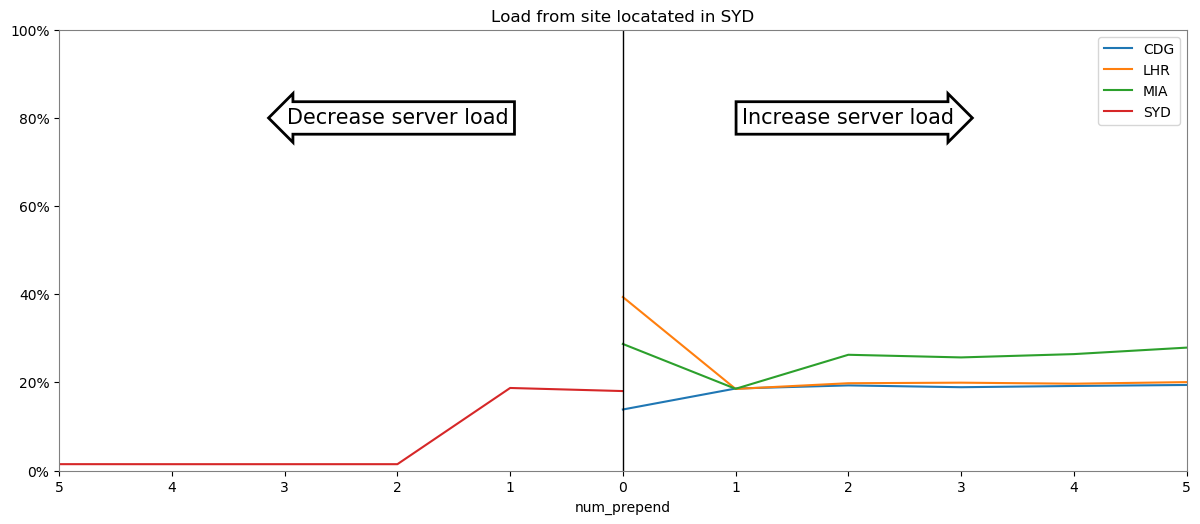

In [149]:
df = df_all
df[['num_prepend','loc_prepend']] = df.bgp.str.split("x",expand=True,)
df_prepend = df.groupby(['num_prepend','loc_prepend','site','bgp'])['percent'].max().reset_index()

for site in df_prepend.site.unique():
    print (site)
    df_site = df_prepend[df_prepend['site']==site]
    (fig,ax) = init_fig()
    for loc_prepend in df_site.loc_prepend.unique():
        df = df_site[(df_site['loc_prepend']==loc_prepend) & (df_site['num_prepend'].astype(int) <6)]  
        reference_value = df_all[(df_all['site']==loc_prepend) & (df_all['bgp']=="baseline")]['percent'].values[0]
        df = df.append([{ 'loc_prepend': loc_prepend, 'percent': reference_value, 'num_prepend': 0 }])
        df = df[['loc_prepend','percent','num_prepend']]
        df["num_prepend"] = df["num_prepend"].astype(int)#         print (reference_value)
        df.sort_values(by="num_prepend",inplace=True)
        if (loc_prepend == site):
            df['num_prepend'] = df['num_prepend'] * -1
        df.set_index('num_prepend',inplace=True)
        df = df[['loc_prepend','percent']]
        print (df)

        
#         ax.annotate("", xy=(0, 5), xytext=(2, 5), arrowprops=dict(arrowstyle="->"))
        df.plot(ax=ax)
        
    # remove negative values label from xticks
    def format_func(value, tick_number):
        return (int(abs(value*-1)))

    ax.xaxis.set_major_locator(plt.MaxNLocator(len(df)*2))
    ax.xaxis.set_major_formatter(plt.FuncFormatter(format_func))
    ax.legend(df_site.loc_prepend.unique().tolist())
    ax.axvline(x=0, color='black',linewidth=1)
    ax.set_title("Load from site locatated in {}".format(site));    
    ax.set_ylim(ymax=100,ymin=0);


    bbox_props = dict(boxstyle="larrow,pad=0.3", fc="white", ec="k", lw=2)
    ax.text(-2, 80, "Decrease server load", ha="center", va="center", rotation=0,size=15, bbox=bbox_props)
    bbox_props = dict(boxstyle="rarrow,pad=0.3", fc="white", ec="k", lw=2)
    ax.text(2, 80, "Increase server load", ha="center", va="center", rotation=0,size=15, bbox=bbox_props)
    
    plt.gca().set_yticklabels(['{:.0f}%'.format(x*1) for x in plt.gca().get_yticks()]);

    plt.show()
 
 

## version 3

In [24]:
# df_full.head()
# # no_prepend_value = df_full[(df_full.bgp=="baseline") & (df_full.site==site)]['percent']
# site="MIA"
# df_site = df_full[df_full['site']==site]
# # df_site[['num_prepend','loc_prepend']] = df_site.bgp.str.split("x",expand=True)
# # # add info for baseline
# # df_site.loc[df_site['num_prepend'] == "baseline",'num_prepend'] = 0 
# df_site

# lets check the variations on site = MIA

In [25]:
df = df_full
df [['num_prepend','loc_prepend']] = df.bgp.str.split("x",expand=True)

df.loc[df['num_prepend'] == "baseline",'num_prepend'] = 0 
df['num_prepend'] = df['num_prepend'].astype(int)
df['num_prepend'] = df.apply(lambda x:x['num_prepend'] if (x['type'] == "positive") else (x['num_prepend'])*-1, axis=1)
df.head()
# df['loc_prepend'] = df.apply(lambda x:x['site'] if (x['loc_prepend'] == None) else  x['loc_prepend'] , axis=1)
# df = df[['site','percent','num_prepend','loc_prepend']]

# # df_full[(df_full.loc_prepend==prepend_site) &(df_full.num_prepend==0)][['site','percent','num_prepend','loc_prepend']]
# df.head()

site    count      type    percent    bgp  num_prepend loc_prepend
0  MIA  1418891  positive  40.672346  5xLHR            5         LHR
1  CDG  1040796  positive  29.834297  5xLHR            5         LHR
2  SYD   700082  positive  20.067770  5xLHR            5         LHR
3  LHR   328820  positive   9.425587  5xLHR            5         LHR
0  LHR  2134984  negative  60.249539  1xMIA           -1         MIA

In [26]:
df[df['num_prepend']==0]

site    count  type    percent       bgp  num_prepend loc_prepend
0  LHR  1381428  None  39.374557  baseline            0        None
1  MIA  1007844  None  28.726370  baseline            0        None
2  SYD   632906  None  18.039589  baseline            0        None
3  CDG   486250  None  13.859484  baseline            0        None

28.726369758763752
28.726369758763752


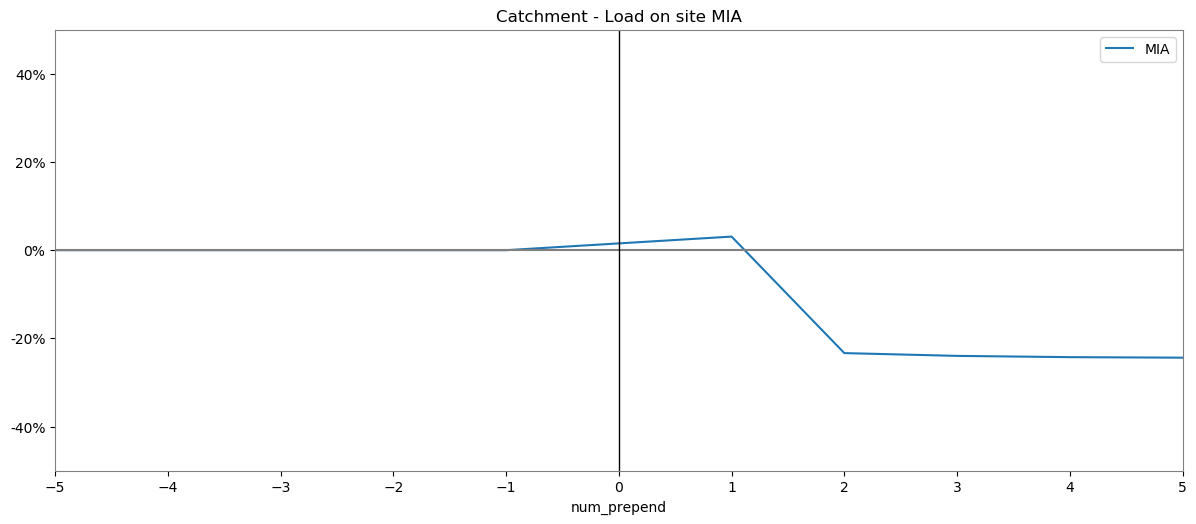

In [49]:
site = "MIA"

prepend_site = "MIA"
df_load_site = df[df['site']==site].copy()
print (df[(df['num_prepend']==0) &  (df['site']==site)]['percent'].values[0])
reference = (df[(df['num_prepend']==0) &  (df['site']==site)]['percent'].values[0])
print (reference)

df_load_site = df_load_site[df_load_site.loc_prepend==prepend_site].sort_values(by="num_prepend")
df_load_site['diff'] =  df_load_site['percent'] - reference

# no records, ignore
df_load_site['diff'] = df_load_site.apply(lambda x:0 if (x['percent'] == 0) else (x['diff']), axis=1)

df_load_site = df_load_site[['site','diff','num_prepend','loc_prepend']]

(fig,ax) = init_fig()
df_load_site.set_index("num_prepend")['diff'].plot(ax=ax)
# ax.set_xlim(xmax=100) 
ax.set_ylim(ymax=50,ymin=-50);
ax.axhline(y=0, xmin=-1, xmax=1.0, color='grey')
ax.axvline(x=0, color='black',linewidth=1)
ax.xaxis.set_major_locator(plt.MaxNLocator(len(df_load_site)*1))
ax.set_title("Catchment - Load on site {}".format(site));    
ax.set_yticklabels(['{:.0f}%'.format(x*1) for x in plt.gca().get_yticks()]);
ax.legend(df_load_site.loc_prepend.unique().tolist());




# BACKUP

LHR
28.726369758763752
28.726369758763752
MIA
28.726369758763752
28.726369758763752
SYD
28.726369758763752
28.726369758763752
CDG
28.726369758763752
28.726369758763752
None
28.726369758763752
28.726369758763752


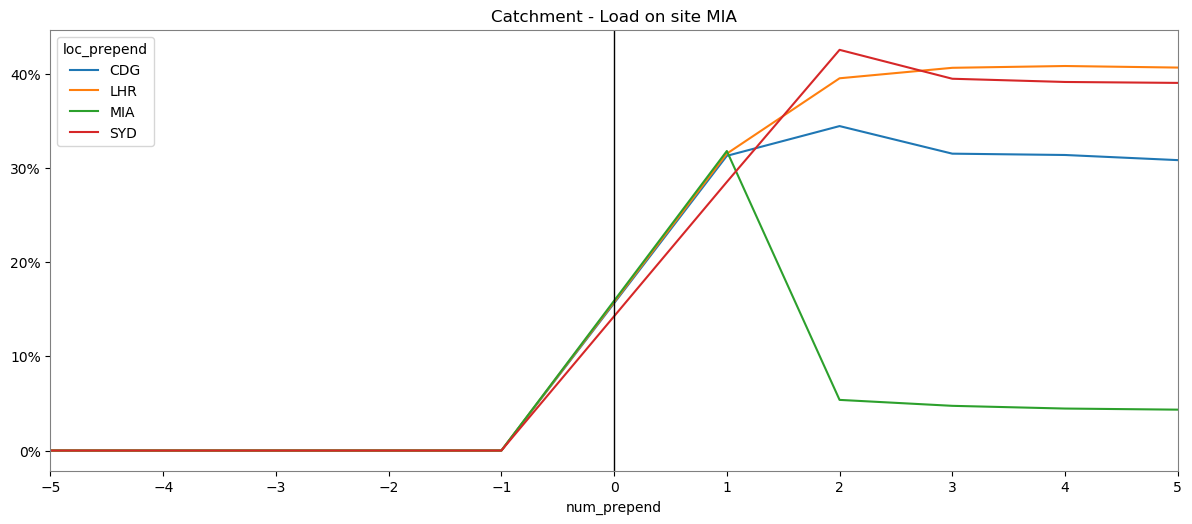

In [147]:
site = "MIA"

df_result = pd.DataFrame()

for prepend_site in df_full.loc_prepend.unique():

    print (prepend_site)
    df_load_site = df[df['site']==site].copy()
    
    print (df[(df['num_prepend']==0) &  (df['site']==site)]['percent'].values[0])
    reference = (df[(df['num_prepend']==0) &  (df['site']==site)]['percent'].values[0])
    print (reference)

    df_load_site = df_load_site[df_load_site.loc_prepend==prepend_site].sort_values(by="num_prepend")
    df_load_site['diff'] =  df_load_site['percent'] - reference

    # no records, ignore
    #df_load_site['diff'] = df_load_site.apply(lambda x:0 if (x['percent'] == 0) else (x['diff']), axis=1)

    df_load_site = df_load_site[['site','diff','num_prepend','loc_prepend','percent']]

    df_load_site.drop_duplicates(inplace=True)
    df_result = pd.concat([df_result,df_load_site])
    
df_result
# (fig,ax) = init_fig()
# df_load_site.set_index("num_prepend")['diff'].plot(ax=ax)
# # ax.set_xlim(xmax=100) 
# ax.set_ylim(ymax=50,ymin=-50);
# ax.axhline(y=0, xmin=-1, xmax=1.0, color='grey')
# ax.axvline(x=0, color='black',linewidth=1)
# ax.xaxis.set_major_locator(plt.MaxNLocator(len(df_load_site)*1))
# ax.set_title("Catchment - Load on site {}".format(site));    
# ax.set_yticklabels(['{:.0f}%'.format(x*1) for x in plt.gca().get_yticks()]);
# ax.legend(df_load_site.loc_prepend.unique().tolist())

# # plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5));

def transform_row(row):
    if (row['num_prepend'] < 0):
        return (0)
    else:
        return row['percent']
        
df_result['percent'] = df_result.apply(transform_row, axis=1)

a = pd.pivot_table(df_result,index=["loc_prepend"],values=["percent"],columns=["num_prepend"]).fillna(0).droplevel(0, axis=1) 
(fig,ax) = init_fig()
a = a.T
a.plot(ax=ax)
ax.axvline(x=0, color='black',linewidth=1)
ax.xaxis.set_major_locator(plt.MaxNLocator(len(a)*1))
ax.set_title("Catchment - Load on site {}".format(site));    
ax.set_yticklabels(['{:.0f}%'.format(x*1) for x in plt.gca().get_yticks()]);

In [125]:
df_result = pd.DataFrame()

site = "MIA"
for prepend_site in df_full.loc_prepend.unique():

    print (prepend_site)
    df_load_site = df[df['site']==site].copy()
    
    print (df[(df['num_prepend']==0) &  (df['site']==site)]['percent'].values[0])
    reference = (df[(df['num_prepend']==0) &  (df['site']==site)]['percent'].values[0])
    print (reference)

    df_load_site = df_load_site[df_load_site.loc_prepend==prepend_site].sort_values(by="num_prepend")
    df_load_site['diff'] =  df_load_site['percent'] - reference

    # no records, ignore
    #df_load_site['diff'] = df_load_site.apply(lambda x:0 if (x['percent'] == 0) else (x['diff']), axis=1)

    df_load_site = df_load_site[['site','diff','num_prepend','loc_prepend','percent']]

    df_load_site.drop_duplicates(inplace=True)
    df_result = pd.concat([df_result,df_load_site])
    
df_result.head()

LHR
28.726369758763752
28.726369758763752
MIA
28.726369758763752
28.726369758763752
SYD
28.726369758763752
28.726369758763752
CDG
28.726369758763752
28.726369758763752
None
28.726369758763752
28.726369758763752


site       diff  num_prepend loc_prepend    percent
1  MIA   2.806270            1         LHR  31.532640
0  MIA  10.808653            2         LHR  39.535023
0  MIA  11.921045            3         LHR  40.647415
0  MIA  12.111683            4         LHR  40.838053
0  MIA  11.945977            5         LHR  40.672346

LHR
28.726369758763752
28.726369758763752
MIA
28.726369758763752
28.726369758763752
SYD
28.726369758763752
28.726369758763752
CDG
28.726369758763752
28.726369758763752
None
28.726369758763752
28.726369758763752


loc_prepend       CDG        LHR        MIA        SYD
num_prepend                                           
-5           0.000000   0.000000   0.000000   0.000000
-4           0.000000   0.000000   0.000000   0.000000
-3           0.000000   0.000000   0.000000   0.000000
-2           0.000000   0.000000   0.000000   0.000000
-1           0.000000   0.000000   0.000000   0.000000
 1           2.572918   2.806270   3.084832  -0.201828
 2           5.732324  10.808653 -23.346687  13.829387
 3           2.802780  11.921045 -23.977607  10.759194
 4           2.662062  12.111683 -24.266706  10.416902
 5           2.117200  11.945977 -24.383280  10.318555

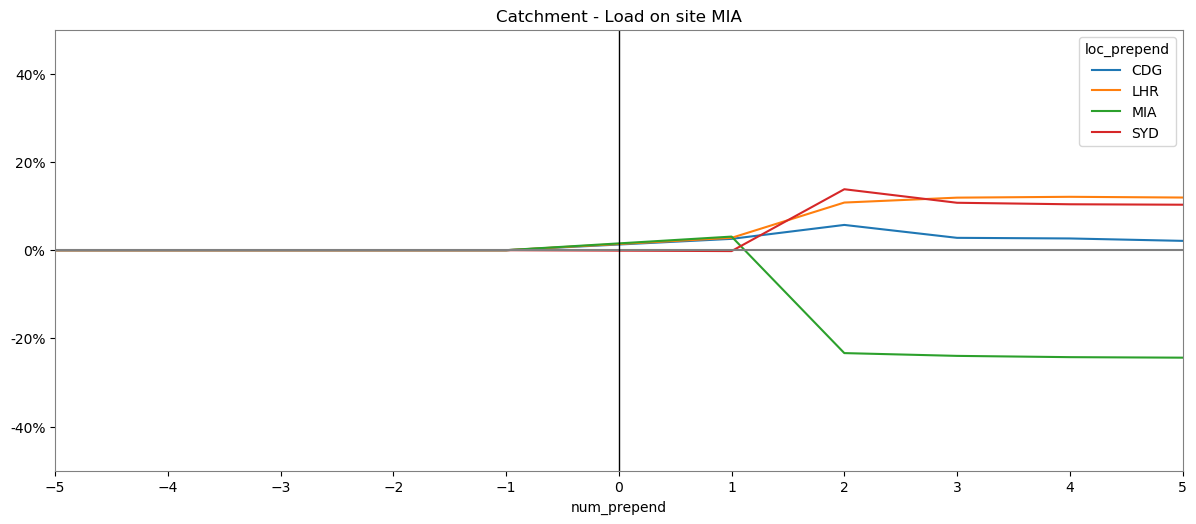

In [148]:
df_result = pd.DataFrame()

site = "MIA"
for prepend_site in df_full.loc_prepend.unique():

    print (prepend_site)
    df_load_site = df[df['site']==site].copy()
    
    print (df[(df['num_prepend']==0) &  (df['site']==site)]['percent'].values[0])
    reference = (df[(df['num_prepend']==0) &  (df['site']==site)]['percent'].values[0])
    print (reference)

    df_load_site = df_load_site[df_load_site.loc_prepend==prepend_site].sort_values(by="num_prepend")
    df_load_site['diff'] =  df_load_site['percent'] - reference

    # no records, ignore
    #df_load_site['diff'] = df_load_site.apply(lambda x:0 if (x['percent'] == 0) else (x['diff']), axis=1)

    df_load_site = df_load_site[['site','diff','num_prepend','loc_prepend','percent']]

    df_load_site.drop_duplicates(inplace=True)
    df_result = pd.concat([df_result,df_load_site])
    
df_result.head() 

def transform_row(row):
    if (row['num_prepend'] < 0):
        return (0)
    else:
        return row['diff']
        
df_result['diff'] = df_result.apply(transform_row, axis=1)
df_result.head()
a = pd.pivot_table(df_result,index=["loc_prepend"],values=["diff"],columns=["num_prepend"]).fillna(0).droplevel(0, axis=1) 
(fig,ax) = init_fig()
a = a.T
a.plot(ax=ax)
ax.xaxis.set_major_locator(plt.MaxNLocator(len(a)*1))
ax.axhline(y=0, xmin=-1, xmax=1.0, color='grey')
ax.axvline(x=0, color='black',linewidth=1)
ax.set_ylim(ymax=50,ymin=-50);
ax.set_title("Catchment - Load on site {}".format(site));    
ax.set_yticklabels(['{:.0f}%'.format(x*1) for x in plt.gca().get_yticks()]);
fig.savefig("./../../images/mia-prepend-diff.pdf", bbox_inches='tight', dpi=1200)

a


LHR
39.374557494125575
39.374557494125575
  site       diff  num_prepend loc_prepend    percent
0  LHR   0.000000            0         NaN   0.000000
0  LHR  -0.559490            1         LHR  38.815068
3  LHR -25.291203            2         LHR  14.083354
3  LHR -29.685767            3         LHR   9.688790
3  LHR -29.945136            4         LHR   9.429421
3  LHR -29.948970            5         LHR   9.425587
MIA
39.374557494125575
39.374557494125575
  site       diff  num_prepend loc_prepend    percent
0  LHR  20.244074           -5         MIA  59.618631
0  LHR  18.939228           -4         MIA  58.313785
0  LHR  20.608542           -3         MIA  59.983100
0  LHR  20.748322           -2         MIA  60.122879
0  LHR  20.874982           -1         MIA  60.249539
0  LHR   0.000000            0         NaN   0.000000
0  LHR  -0.875138            1         MIA  38.499419
0  LHR  12.735175            2         MIA  52.109733
0  LHR  12.503422            3         MIA  51.87797

loc_prepend       CDG        LHR        MIA       SYD
num_prepend                                          
-5           0.000000   0.000000   0.000000  0.000000
-4           0.000000   0.000000   0.000000  0.000000
-3           0.000000   0.000000   0.000000  0.000000
-2           0.000000   0.000000   0.000000  0.000000
-1           0.000000   0.000000   0.000000  0.000000
 1          -3.564447  -0.559490  -0.875138 -0.820537
 2           5.544914 -25.291203  12.735175  1.008013
 3           9.201123 -29.685767  12.503422  0.267162
 4           9.074486 -29.945136  11.918247 -0.772944
 5           9.458983 -29.948970  11.760658 -0.702237

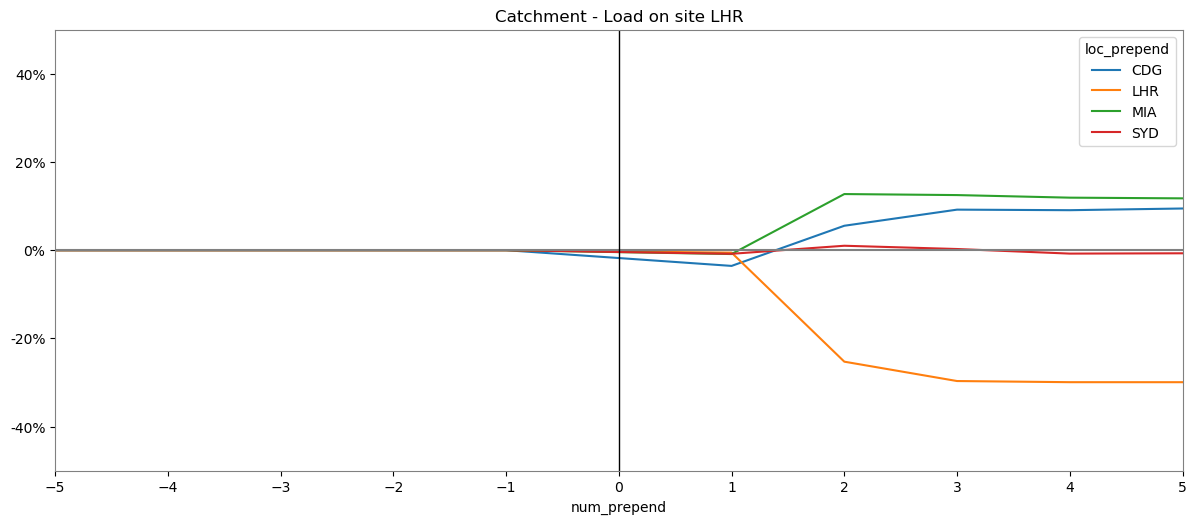

In [142]:
df_result = pd.DataFrame()

site = "LHR"
for prepend_site in df_full.loc_prepend.unique():

    print (prepend_site)
    df_load_site = df[df['site']==site].copy()
    
    print (df[(df['num_prepend']==0) &  (df['site']==site)]['percent'].values[0])
    reference = (df[(df['num_prepend']==0) &  (df['site']==site)]['percent'].values[0])
    print (reference)

            

    df_load_site = df_load_site[df_load_site.loc_prepend==prepend_site].sort_values(by="num_prepend")
    df_load_site['diff'] =  df_load_site['percent'] - reference

    # no records, ignore
    #df_load_site['diff'] = df_load_site.apply(lambda x:0 if (x['percent'] == 0) else (x['diff']), axis=1)

    df_load_site = df_load_site[['site','diff','num_prepend','loc_prepend','percent']]
    df_load_site = df_load_site.append([{ 'site': site, 'diff': 0, 'num_prepend': 0,  'percent':0}]).sort_values(by="num_prepend")


    print (df_load_site)
    df_load_site.drop_duplicates(inplace=True)
    df_result = pd.concat([df_result,df_load_site])
    
df_result.head() 

def transform_row(row):
    if (row['num_prepend'] < 0):
        return (0)
    else:
        return row['diff']
        
df_result['diff'] = df_result.apply(transform_row, axis=1)
df_result.head()
a = pd.pivot_table(df_result,index=["loc_prepend"],values=["diff"],columns=["num_prepend"]).fillna(0).droplevel(0, axis=1) 
(fig,ax) = init_fig()
a = a.T
a.plot(ax=ax)
ax.xaxis.set_major_locator(plt.MaxNLocator(len(a)*1))
ax.axhline(y=0, xmin=-1, xmax=1.0, color='grey')
ax.axvline(x=0, color='black',linewidth=1)
ax.set_ylim(ymax=50,ymin=-50);
ax.set_title("Catchment - Load on site {}".format(site));    
ax.set_yticklabels(['{:.0f}%'.format(x*1) for x in plt.gca().get_yticks()]);
a


LHR
39.374557494125575
39.374557494125575
MIA
39.374557494125575
39.374557494125575
SYD
39.374557494125575
39.374557494125575
CDG
39.374557494125575
39.374557494125575
None
39.374557494125575
39.374557494125575


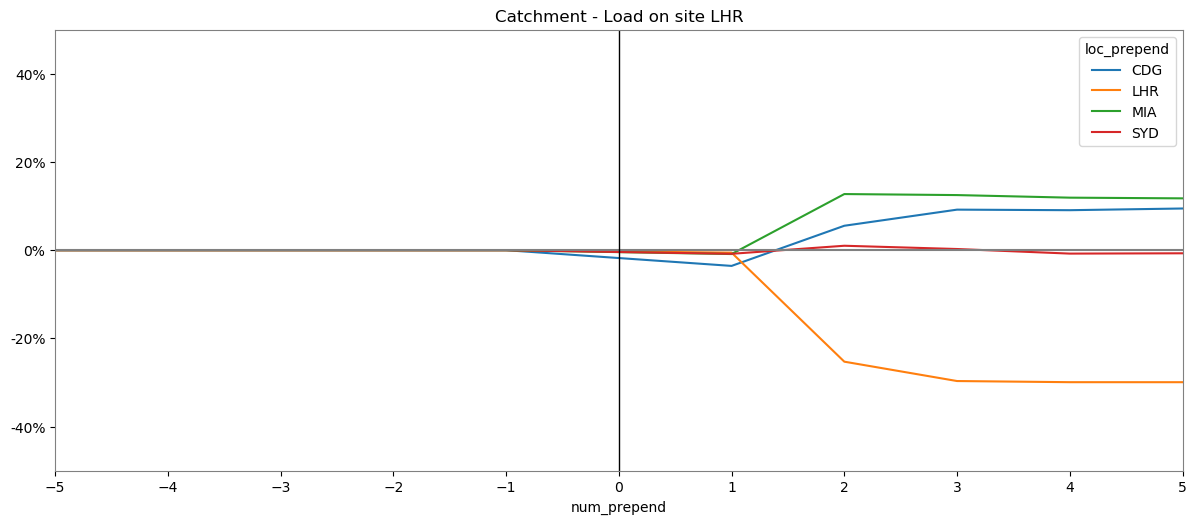

In [130]:
df_result = pd.DataFrame()

site = "LHR"
for prepend_site in df_full.loc_prepend.unique():

    print (prepend_site)
    df_load_site = df[df['site']==site].copy()
    
    print (df[(df['num_prepend']==0) &  (df['site']==site)]['percent'].values[0])
    reference = (df[(df['num_prepend']==0) &  (df['site']==site)]['percent'].values[0])
    print (reference)

    df_load_site = df_load_site[df_load_site.loc_prepend==prepend_site].sort_values(by="num_prepend")
    df_load_site['diff'] =  df_load_site['percent'] - reference

    # no records, ignore
    #df_load_site['diff'] = df_load_site.apply(lambda x:0 if (x['percent'] == 0) else (x['diff']), axis=1)

    df_load_site = df_load_site[['site','diff','num_prepend','loc_prepend','percent']]

    df_load_site.drop_duplicates(inplace=True)
    df_result = pd.concat([df_result,df_load_site])
    
df_result.head() 

def transform_row(row):
    if (row['num_prepend'] < 0):
        return (0)
    else:
        return row['diff']
        
df_result['diff'] = df_result.apply(transform_row, axis=1)
df_result.head()
a = pd.pivot_table(df_result,index=["loc_prepend"],values=["diff"],columns=["num_prepend"]).fillna(0).droplevel(0, axis=1) 
(fig,ax) = init_fig()
a = a.T
a.plot(ax=ax)
ax.xaxis.set_major_locator(plt.MaxNLocator(len(a)*1))
ax.axhline(y=0, xmin=-1, xmax=1.0, color='grey')
ax.axvline(x=0, color='black',linewidth=1)
ax.set_ylim(ymax=50,ymin=-50);
ax.set_title("Catchment - Load on site {}".format(site));    
ax.set_yticklabels(['{:.0f}%'.format(x*1) for x in plt.gca().get_yticks()]);



LHR
13.859483506573314
13.859483506573314
MIA
13.859483506573314
13.859483506573314
SYD
13.859483506573314
13.859483506573314
CDG
13.859483506573314
13.859483506573314
None
13.859483506573314
13.859483506573314


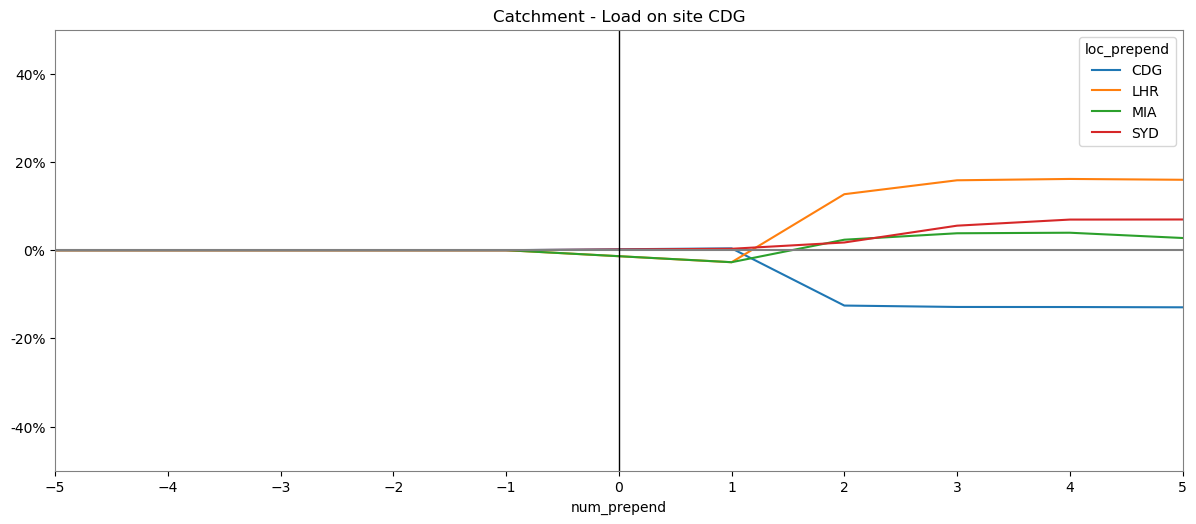

In [132]:
df_result = pd.DataFrame()

site = "CDG"
for prepend_site in df_full.loc_prepend.unique():

    print (prepend_site)
    df_load_site = df[df['site']==site].copy()
    
    print (df[(df['num_prepend']==0) &  (df['site']==site)]['percent'].values[0])
    reference = (df[(df['num_prepend']==0) &  (df['site']==site)]['percent'].values[0])
    print (reference)

    df_load_site = df_load_site[df_load_site.loc_prepend==prepend_site].sort_values(by="num_prepend")
    df_load_site['diff'] =  df_load_site['percent'] - reference

    # no records, ignore
    #df_load_site['diff'] = df_load_site.apply(lambda x:0 if (x['percent'] == 0) else (x['diff']), axis=1)

    df_load_site = df_load_site[['site','diff','num_prepend','loc_prepend','percent']]

    df_load_site.drop_duplicates(inplace=True)
    df_result = pd.concat([df_result,df_load_site])
    
df_result.head() 

def transform_row(row):
    if (row['num_prepend'] <= 0):
        return (0)
    else:
        return row['diff']
        
df_result['diff'] = df_result.apply(transform_row, axis=1)
df_result.head()
a = pd.pivot_table(df_result,index=["loc_prepend"],values=["diff"],columns=["num_prepend"]).fillna(0).droplevel(0, axis=1) 
(fig,ax) = init_fig()
a = a.T
a.plot(ax=ax)
ax.xaxis.set_major_locator(plt.MaxNLocator(len(a)*1))
ax.axhline(y=0, xmin=-1, xmax=1.0, color='grey')
ax.axvline(x=0, color='black',linewidth=1)
ax.set_ylim(ymax=50,ymin=-50);
ax.set_title("Catchment - Load on site {}".format(site));    
ax.set_yticklabels(['{:.0f}%'.format(x*1) for x in plt.gca().get_yticks()]);



line LHR
line MIA
line SYD
line CDG


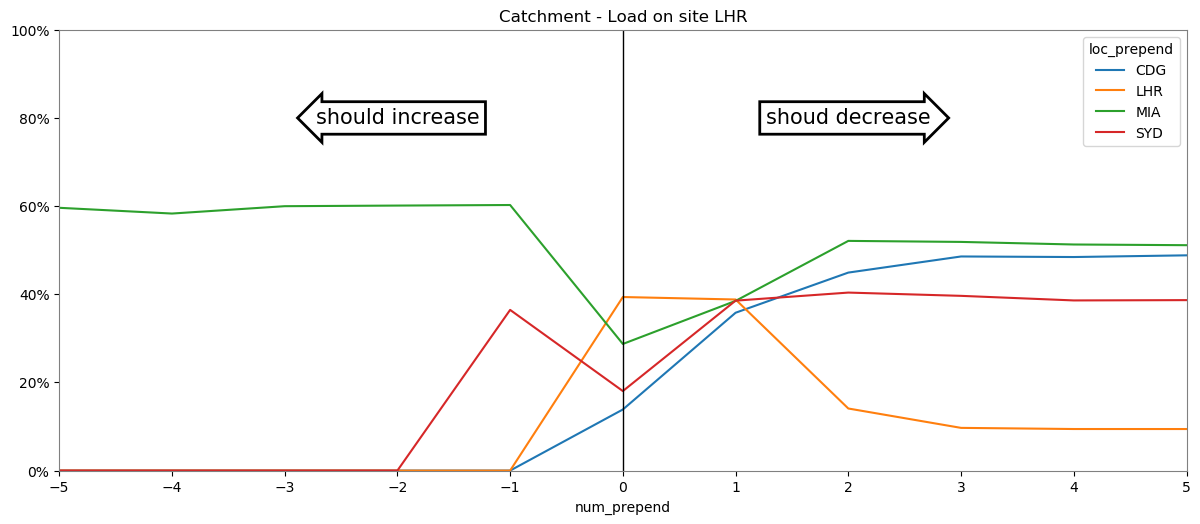

In [757]:
# load

site = "LHR"
df_load_site = df[df['site']==site]

# (fig,ax) = init_fig()

df_result = pd.DataFrame()
for prepend_site in df_full.loc_prepend.unique():
# for prepend_site in  ["MIA"]:
    prepend_site
    print ("line {}".format(prepend_site))
    df_temp = df_load_site[df_load_site['loc_prepend'] == prepend_site]
    df_reference = df_full[(df_full.loc_prepend==prepend_site) &(df_full.num_prepend==0)][['site','percent','num_prepend','loc_prepend']]
    df_temp = pd.concat([df_temp, df_reference])
    df_temp['site'] = site
    df_temp.drop_duplicates(inplace=True)
    df_result = pd.concat([df_result,df_temp])


a = pd.pivot_table(df_result,index=["loc_prepend"],values=["percent"],columns=["num_prepend"]).fillna(0).droplevel(0, axis=1) 
(fig,ax) = init_fig()
a = a.T
a.plot(ax=ax)


ax.xaxis.set_major_locator(plt.MaxNLocator(len(a)*1))
# ax.legend(df_site.site.unique().tolist())

ax.axvline(x=0, color='black',linewidth=1)
ax.set_title("Catchment - Load on site {}".format(site));    
ax.set_ylim(ymax=100,ymin=0);


bbox_props = dict(boxstyle="larrow,pad=0.3", fc="white", ec="k", lw=2)
ax.text(-2, 80, "should increase", ha="center", va="center", rotation=0,size=15, bbox=bbox_props)
bbox_props = dict(boxstyle="rarrow,pad=0.3", fc="white", ec="k", lw=2)
ax.text(2, 80, "shoud decrease", ha="center", va="center", rotation=0,size=15, bbox=bbox_props)

# % percentage label
ax.set_yticklabels(['{:.0f}%'.format(x*1) for x in plt.gca().get_yticks()]);

In [739]:
df_temp.sort_values(by="num_prepend")

site    percent  num_prepend loc_prepend
1  MIA  27.497815           -5         MIA
1  MIA  28.149163           -4         MIA
1  MIA  27.319418           -3         MIA
1  MIA  27.267562           -2         MIA
1  MIA  27.172266           -1         MIA
1  MIA  28.726370            0         MIA
1  MIA  31.811202            1         MIA
1  MIA  26.273078            2         MIA
1  MIA  25.673642            3         MIA
1  MIA  26.424852            4         MIA
1  MIA  27.894217            5         MIA

In [690]:
a = a.droplevel(0, axis=1) 
a

num_prepend   -5   -4   -3   -2         -1          0          1          2  \
loc_prepend                                                                   
CDG          0.0  0.0  0.0  0.0   0.000000  13.859484  14.274683   1.297392   
LHR          0.0  0.0  0.0  0.0   0.000000  39.374557  11.126059  14.083354   
MIA          0.0  0.0  0.0  0.0   0.000000  28.726370  11.135899   5.379683   
SYD          0.0  0.0  0.0  0.0  16.395203  18.039589  14.180886   1.452281   

num_prepend         3         4         5  
loc_prepend                                
CDG          0.980078  0.965632  0.901164  
LHR          9.688790  9.429421  9.425587  
MIA          4.748763  4.459663  4.343089  
SYD          1.450570  1.450691  1.456837

In [692]:
a = a.droplevel(0, axis=1) 


ValueError: Cannot remove 1 levels from an index with 1 levels: at least one level must be left.

In [643]:
# load
df_load_site = df[df['site']=="LHR"]

# prepend_site = "SYD"
regex_prepend_site = prepend_site+"|baseline"
df_load_site = df_load_site[df_load_site['loc_prepend'].str.contains(regex_prepend_site)]
df_load_site
# df_reference = df_full[(df_full.loc_prepend==prepend_site) &(df_full.num_prepend==0)][['site','percent','num_prepend','loc_prepend']]
# df_load_site = pd.concat([df_load_site, df_reference])
# df_load_site['site'] = site
# df_load_site.sort_values(by="num_prepend")

site    percent  num_prepend loc_prepend
0  LHR  39.143272            4         SYD
0  LHR  38.554021            1         SYD
0  LHR  42.555757            2         SYD
0  LHR  36.455721           -1         SYD
0  LHR  39.044925            5         SYD
0  LHR  39.641719            3         SYD

In [634]:
# load
df_load_site = df[df['site']=="LHR"]

prepend_site = "CDG"
regex_prepend_site = prepend_site+"|baseline"
df_load_site = df_load_site[df_load_site['loc_prepend'].str.contains(regex_prepend_site)]
df_reference = df_full[(df_full.loc_prepend==prepend_site) &(df_full.num_prepend==0)][['site','percent','num_prepend','loc_prepend']]
df_load_site = pd.concat([df_load_site, df_reference])
df_load_site['site'] = site
df_load_site.sort_values(by="num_prepend")

site    percent  num_prepend loc_prepend
3  MIA  13.859484            0         CDG
0  MIA  35.810110            1         CDG
0  MIA  44.919471            2         CDG
0  MIA  48.575681            3         CDG
0  MIA  48.449043            4         CDG
0  MIA  48.833540            5         CDG

In [549]:
def process_df_site(df):
    print (df)

In [562]:
for site in (df.site.unique()):
    print ("load on site {}".format(site))
    df_site = df[df['site'] == site][['site','percent','num_prepend','loc_prepend']]
#     print (df_site)
#     process_df_site(df_site)
df_site.groupby(['site','num_prepend','loc_prepend'])['percent'].max().reset_index()

load on site LHR
load on site MIA
load on site SYD
load on site CDG


site  num_prepend loc_prepend    percent
0   CDG           -5         MIA   0.000000
1   CDG           -4         MIA   0.000000
2   CDG           -3         MIA   0.000000
3   CDG           -2         MIA   0.000000
4   CDG           -1         MIA   0.000000
5   CDG           -1         SYD  16.395203
6   CDG            0         CDG  13.859484
7   CDG            1         CDG  14.274683
8   CDG            1         LHR  11.126059
9   CDG            1         MIA  11.135899
10  CDG            1         SYD  14.180886
11  CDG            2         CDG   1.297392
12  CDG            2         LHR  14.083354
13  CDG            2         MIA   5.379683
14  CDG            2         SYD   1.452281
15  CDG            3         CDG   0.980078
16  CDG            3         LHR   9.688790
17  CDG            3         MIA   4.748763
18  CDG            3         SYD   1.450570
19  CDG            4         CDG   0.965632
20  CDG            4         LHR   9.429421
21  CDG            4         MIA   4.459663
22  CDG            4         SYD   1.450691
23  CDG            5         CDG   0.901164
24  CDG            5         LHR   9.425587
25  CDG            5         MIA   4.343089
26  CDG            5         SYD   1.456837

In [568]:
pd.pivot_table(df_site,index=["loc_prepend"],values=["percent"],columns=["num_prepend"]).fillna(0)

percent                                                  \
num_prepend      -5   -4   -3   -2         -1          0          1   
loc_prepend                                                           
CDG             0.0  0.0  0.0  0.0   0.000000  13.859484  14.274683   
LHR             0.0  0.0  0.0  0.0   0.000000   0.000000  11.126059   
MIA             0.0  0.0  0.0  0.0   0.000000   0.000000  11.135899   
SYD             0.0  0.0  0.0  0.0  16.395203   0.000000  14.180886   

                                                      
num_prepend          2         3         4         5  
loc_prepend                                           
CDG           1.297392  0.980078  0.965632  0.901164  
LHR          14.083354  9.688790  9.429421  9.425587  
MIA           5.379683  4.748763  4.459663  4.343089  
SYD           1.452281  1.450570  1.450691  1.456837

In [442]:
if (df['num_prepend'] == 0):
    print (1)
    
    

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [573]:
# plot prepend on MIAMI
prepend_site = "MIA"
regex_prepend_site = prepend_site+"|baseline"
df_prepend = df_site[df_site['loc_prepend'].str.contains(regex_prepend_site)]
df_prepend = df_prepend.sort_values(by=['type','num_prepend'])

def transform_row(row):
    
    if (row['type']=="negative"):
        return (row['num_prepend']*-1)
    else:
        return (row['num_prepend'])
    
df_prepend['num_prepend'] = df_prepend['num_prepend'].astype(int)
df_prepend['num_prepend'] = df_prepend.apply(transform_row, axis=1)
df_prepend = df_prepend.sort_values(by=['num_prepend'])
# df_prepend.set_index('num_prepend',inplace=True)
# df_prepend = df_prepend[['loc_prepend','percent']]
df_prepend

ValueError: cannot index with vector containing NA / NaN values

In [417]:
for prepend_site in df_prepend.loc_prepend.unique():
    print (prepend_site)

MIA
baseline


In [ ]:
# plot prepend on MIAMI
prepend_site = "MIA"
regex_prepend_site = prepend_site+"|baseline"
df_prepend = df_site[df_site['loc_prepend'].str.contains(regex_prepend_site)]
df_prepend = df_prepend.sort_values(by=['type','num_prepend'])

def transform_row(row):
    
    if (row['type']=="negative"):
        return (row['num_prepend']*-1)
    else:
        return (row['num_prepend'])
    
df_prepend['num_prepend'] = df_prepend['num_prepend'].astype(int)
df_prepend['num_prepend'] = df_prepend.apply(transform_row, axis=1)
df_prepend = df_prepend.sort_values(by=['num_prepend'])
# df_prepend.set_index('num_prepend',inplace=True)
# df_prepend = df_prepend[['loc_prepend','percent']]
df_prepend

In [ ]:
# plot prepend on MIAMI
prepend_site = "MIA"
regex_prepend_site = prepend_site+"|baseline"
df_prepend = df_site[df_site['loc_prepend'].str.contains(regex_prepend_site)]
df_prepend = df_prepend.sort_values(by=['type','num_prepend'])

def transform_row(row):
    
    if (row['type']=="negative"):
        return (row['num_prepend']*-1)
    else:
        return (row['num_prepend'])
    
df_prepend['num_prepend'] = df_prepend['num_prepend'].astype(int)
df_prepend['num_prepend'] = df_prepend.apply(transform_row, axis=1)
df_prepend = df_prepend.sort_values(by=['num_prepend'])
# df_prepend.set_index('num_prepend',inplace=True)
# df_prepend = df_prepend[['loc_prepend','percent']]
df_prepend

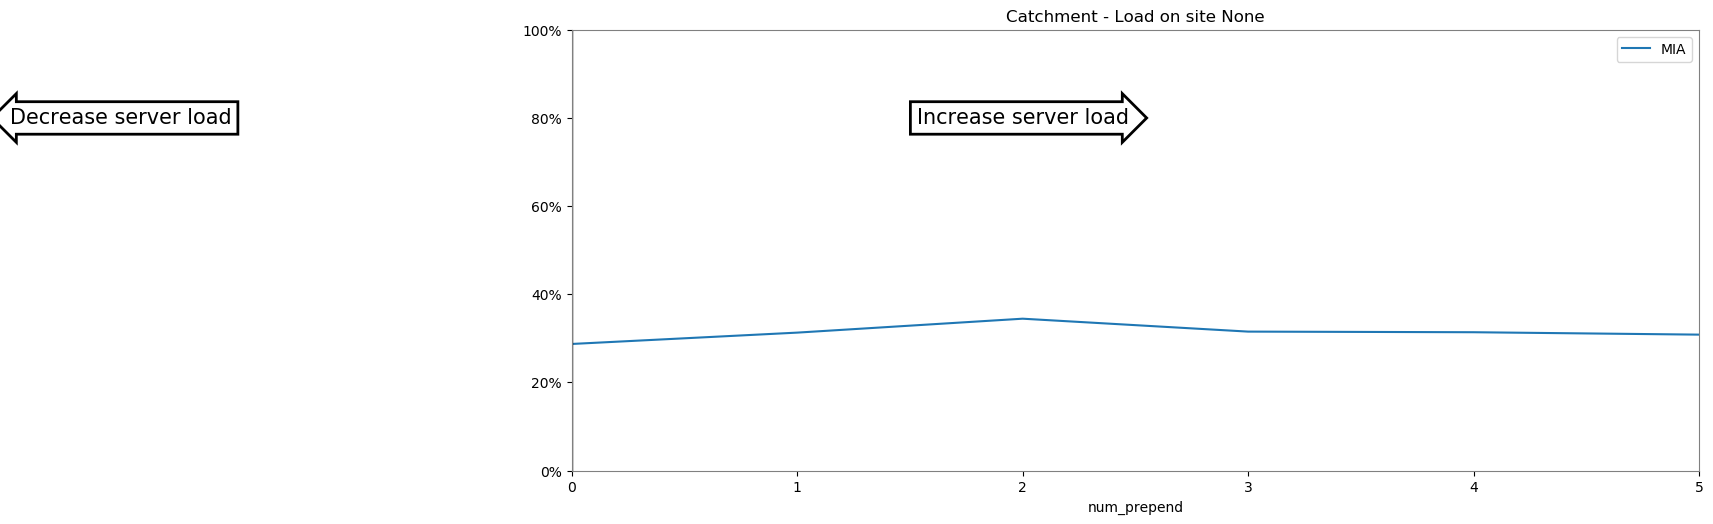

In [411]:
def plot_load_graph(df,site=None,prepend_site=None):
    
    df.plot(ax=ax)

    ax.xaxis.set_major_locator(plt.MaxNLocator(len(df)*1))
    ax.legend(df_site.site.unique().tolist())

    ax.axvline(x=0, color='black',linewidth=1)
    ax.set_title("Catchment - Load on site {}".format(site));    
    ax.set_ylim(ymax=100,ymin=0);


    bbox_props = dict(boxstyle="larrow,pad=0.3", fc="white", ec="k", lw=2)
    ax.text(-2, 80, "Decrease server load", ha="center", va="center", rotation=0,size=15, bbox=bbox_props)
    bbox_props = dict(boxstyle="rarrow,pad=0.3", fc="white", ec="k", lw=2)
    ax.text(2, 80, "Increase server load", ha="center", va="center", rotation=0,size=15, bbox=bbox_props)

    # % percentage label
    ax.set_yticklabels(['{:.0f}%'.format(x*1) for x in plt.gca().get_yticks()]);



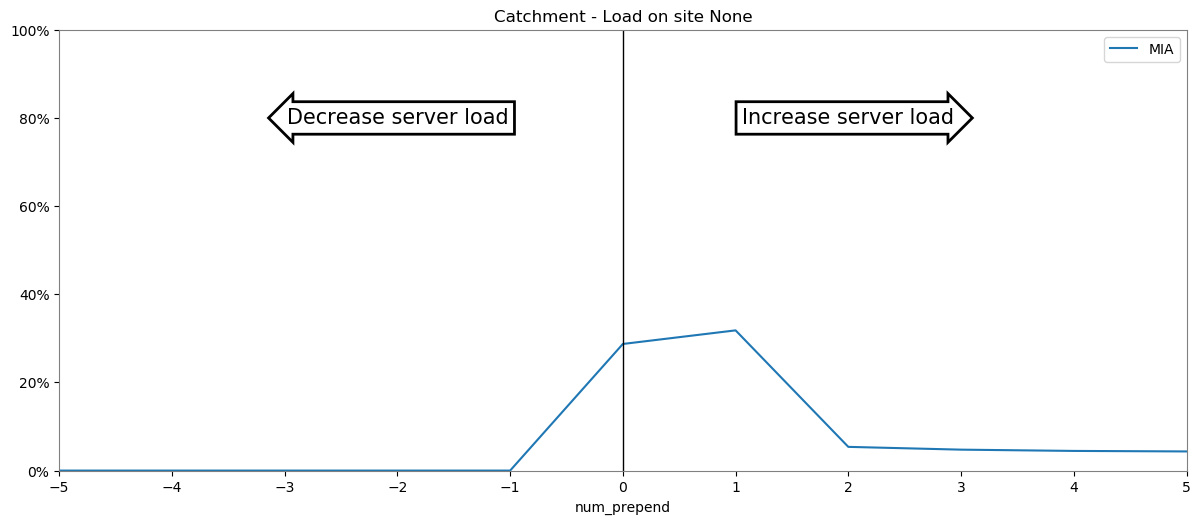

In [400]:
site = prepend_site 
df = df_prepend
plot_load_graph(df_prepend)

In [361]:
# plot prepend on MIAMI
prepend_site = "MIA"

df_prepend = df_site[df_site['loc_prepend'].srt.contains("MIA")]
df_prepend = df_prepend.sort_values(by=['type','num_prepend'])

# df_prepend.set_index('num_prepend',inplace=True)
# df_prepend = df_prepend[['loc_prepend','percent']]
df_prepend
df_prepend.loc[df_prepend['type']=="negative", :]
df_prepend['num_prepend'] = df_prepend['num_prepend'].astype(int)
# df_prepend.apply(lambda x: -x if x['type']=="negative"  else x, axis=1)

# df_prepend.apply(lambda row: EOQ(row['D'], row['p'], ck, ch), axis=1)

# df_prepend.apply(lambda row['num_prepend']: 0 if (1==1) else 1, axis=1)
df_prepend.loc[df_prepend['type'] == "negative",'num_prepend']  

def transform_row(row):
    
    if (row['type']=="negative"):
        return (row['num_prepend']*-1)
    else:
        return (row['num_prepend'])

df_prepend['num_prepend'] = df_prepend.apply(transform_row, axis=1)
df_prepend
# df_prepend.set_index('num_prepend',inplace=True)
# df_prepend = df_prepend[['loc_prepend','percent']]


(fig,ax) = init_fig()
df_prepend.plot()

AttributeError: 'Series' object has no attribute 'srt'

In [ ]:
(fig,ax) = init_fig()

---
---
<h1 align="center"> Radar Graph </h1>

---
---

In [37]:
import plotly.graph_objs as go
import chart_studio.plotly as py
import plotly 

from plotly import exceptions
import plotly.figure_factory as ff

categories = ['processing cost','mechanical properties','chemical stability',
              'thermal stability', 'device integration']

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
      r=[1, 5, 2, 2, 3],
      theta=categories,
      fill='toself',
      name='Product A'
))
fig.add_trace(go.Scatterpolar(
      r=[4, 3, 2.5,0, 2],
      theta=categories,
      fill='toself',
      name='Product B'
))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, 5],
      side="clockwise",
      
    )),
  showlegend=False, 
)

fig.show()

In [38]:
df = df_all
site="CDG"
df_site = df[df.site==site]
# what is the influence of the MIAMI on CDG
bgp = "MIA"
df_site = df_site[df_site.bgp.str.contains(bgp)]


In [39]:
# df_site[~df_site.bgp.str.contains("baseline")]['percent']
df_site = df_site.sort_values('bgp')
df_site

site   count    percent    bgp num_prepend loc_prepend
3  CDG  432969  11.876827  1xMIA           1         MIA
2  CDG  563760  15.739520  2xMIA           2         MIA
2  CDG  567585  15.880804  3xMIA           3         MIA
2  CDG  570930  15.882315  4xMIA           4         MIA
2  CDG  565787  15.554419  5xMIA           5         MIA
1  CDG  837466  22.936476  6xMIA           6         MIA
2  CDG  563358  15.413579  7xMIA           7         MIA
2  CDG  567261  15.763884  8xMIA           8         MIA

In [40]:

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
  r=df_site[~df_site.bgp.str.contains("baseline")]['percent'],
  theta=df_site[~df_site.bgp.str.contains("baseline")]['bgp'],
  fill='tonext',

  marker=dict(color="mediumseagreen"),
  name=bgp,
  
))

fig.update_layout(
    title = 'SITE CDG. BGP prepending on MIA',
  polar=dict(
    radialaxis=dict(
    visible=True,
    range=[0, 30],
    ticksuffix = "%",
    side = "clockwise", 
    )),
  showlegend=False
)
fig.show()

In [41]:
df = df_all
df.bgp.unique()
df = df[df.bgp.str.contains("baseline|MIA")]
# print (bgp)

fig = go.Figure()

for bgp in df.bgp.unique():
#     print (bgp)
    df_bgp = df[df.bgp==bgp]
    df_bgp = df_bgp.sort_values('site')
    fig.add_trace(
    go.Scatterpolar(
      r=df_bgp['percent'],
      theta=df_bgp['site'],
      fill='toself',
      name=bgp,
    ))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      side="clockwise",
      range=[0, 50],
      ticksuffix = "%",
      
    )),
  showlegend=True, 
)
fig.show()

In [42]:

df = df_all
for bgp in df.bgp.unique():
    print (bgp)
    
    fig = go.Figure()

    fig.update_layout(
      polar=dict(
        radialaxis=dict(
        visible=True,
        range=[0, 60],
        ticksuffix = "%",
#         title = "teste",
        )),
      showlegend=False
    )
    df_bgp = df[df.bgp==bgp]
    df_bgp = df_bgp.sort_values('site')

    fig.add_trace(go.Scatterpolar(
          r=df_bgp['percent'],
          theta=df_bgp['site'],
          fill='toself',
          marker=dict(color="mediumseagreen"),

          name=bgp,
    ))
    fig.show()

2xCDG


5xMIA


6xSYD


3xSYD


2xLHR


4xCDG


1xLHR


3xMIA


5xSYD


6xMIA


1xCDG


4xLHR


8xMIA


3xLHR


2xSYD


1xMIA


7xSYD


4xMIA


3xCDG


5xLHR


baseline


7xMIA


4xSYD


2xMIA


1xSYD


8xSYD


5xCDG


---
---
<h1 align="center"> Degrees of control of each site </h1>

---
---

In [43]:
def bins_and_edges(df, variable,bin_size):
 """
     split the variable in chunks and group based on the bin size
 """    
 bins = list (range(0,100,bin_size))
 print(bins)
 df['binned'] = pd.cut(df[variable], bins)
 return (df)

In [44]:
def print_edges(df,bin_size,variable):
    
    # all xlabels
    all_markers = df.index.to_list()
    
    # bin the dataframe
    bins = list (range(0,100,bin_size))
    df['binned'] = pd.cut(df[variable], bins)  
    
    # list of edges
    list_edges =[]
    # find the eages of each group
    first = df.drop_duplicates('binned', keep="first") 
    last = df.drop_duplicates('binned', keep="last") 
    markers = pd.concat([first,last]).reset_index()['bgp'].to_list()

    # translate label to xlabel index
    list_index = []
    for xlabel in  markers: 
        index = all_markers.index(xlabel)
        list_index.append(index)
    list_index.sort()
    
    counter = 0
    label_counter = 0
    previous = 0
    for index in list_index:

        previous = list_index[counter-1]
        current = list_index[counter]
        if (counter == 0):
            previous = 0

#         print ("[{} - {}] ".format(previous,current))
        
        initial = previous
        last = current

        edges = { "initial": initial,
                  "final":  last,
        }
        list_edges.append(edges)

        if (initial == last):
            counter+=1
            continue
            
        if (label_counter % 2) == 0:
            color = "gray"
            position = 50
        else:
            color = "red"
            position = 50

        counter+=1     
        
        # print area
        ax.fill_betweenx([0,100], initial, last, facecolor=color,alpha=0.1, linestyle='dotted')
        
        # print border
        ax.axvline(x=index, color='grey',linewidth=0.8,linestyle='dotted')
        
        # label position
        middle = (last-initial)/2 + initial
        
        label_counter+=1
        label = "degree {}".format(label_counter)
        ax.annotate(label,
                     xy=(middle, position),
                     rotation=90,
                     color='black',
                     horizontalalignment='left', 
                     va='bottom') 
    return list_edges

## DEGREES OF CONTROL

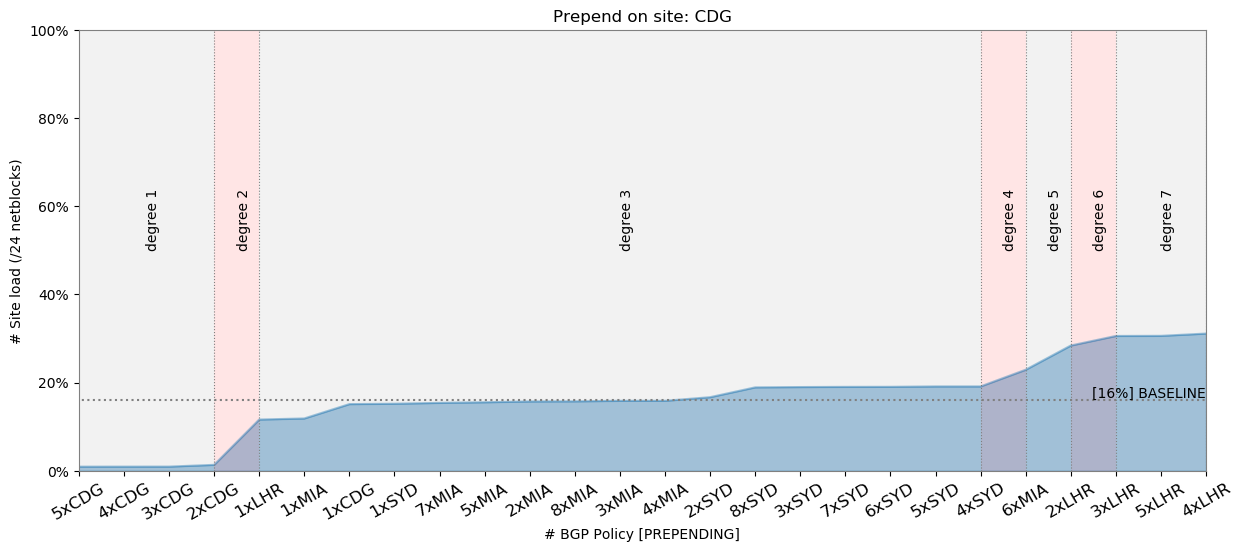

In [45]:
df = df_all
df_site = df[df['site']=="CDG"].sort_values(by="bgp")
df_site=df_site[~df_site.bgp.str.contains('baseline')]
data = df_site[["percent","bgp"]] 
data.set_index('bgp',inplace=True)
data = data.sort_values(by="percent")

# FIGURE
(fig,ax) = init_fig()
data['percent'].plot(ax=ax, kind='area', alpha=.4)

# Xticks
xlabels = data.index.get_level_values(0).tolist()
ax.xaxis.set_tick_params(labelsize=12)
ax.set_ylim(ymax=100);
ax.set_xlim(xmin=0);
plt.xticks(np.arange(len(data)), xlabels, rotation=30)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*1) for x in plt.gca().get_yticks()]) 

# labels
ax.set_xlabel('# BGP Policy [PREPENDING]');
ax.set_ylabel('# Site load (/24 netblocks)');
ax.set_title("Prepend on site: {}".format(site))


# REFERENCE LINE
get_and_plot_reference_value(df,"CDG")

# FILL EDGES AREA
list_edges = print_edges(data,10,'percent')
# print (list_edges)
plt.show()

# ALL nodes

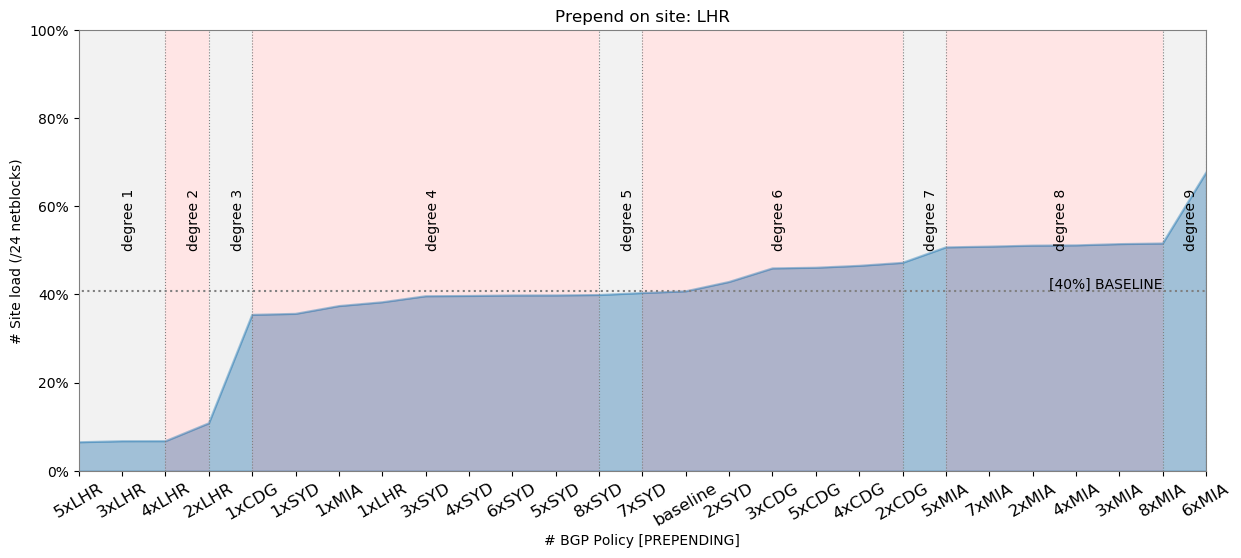

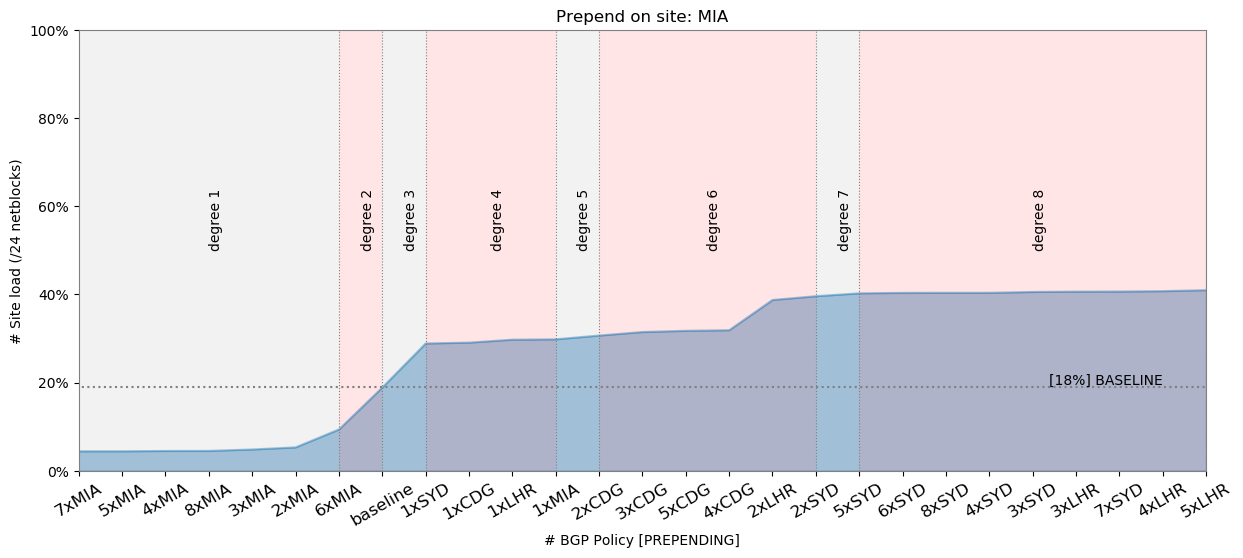

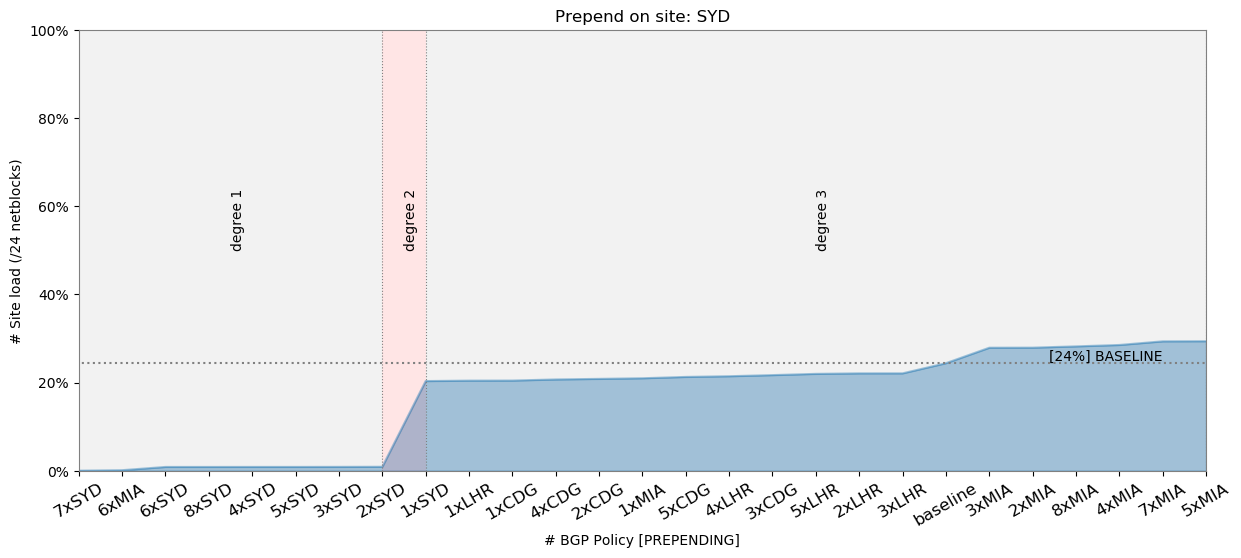

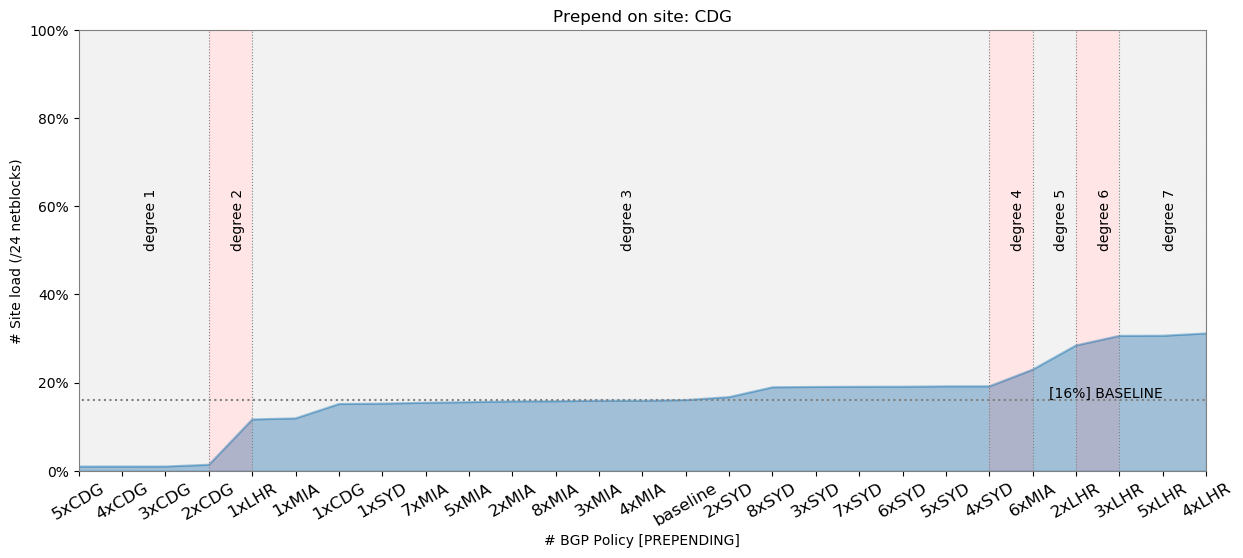

In [46]:
df = df_all
for site in df.site.unique():
    
    df_site = df[df['site']==site].sort_values(by="bgp")
#     df_site=df_site[~df_site.bgp.str.contains('baseline')]
    data = df_site[["percent","bgp"]] 
    data.set_index('bgp',inplace=True)
    data = data.sort_values(by="percent")
    
    # FIGURE
    (fig,ax) = init_fig()
    data['percent'].plot(ax=ax, kind='area', alpha=.4)

    # Xticks
    xlabels = data.index.get_level_values(0).tolist()
    ax.xaxis.set_tick_params(labelsize=12)
    ax.set_ylim(ymax=100);
    ax.set_xlim(xmin=0);
    plt.xticks(np.arange(len(data)), xlabels, rotation=30)
    plt.gca().set_yticklabels(['{:.0f}%'.format(x*1) for x in plt.gca().get_yticks()]) 

    # labels
    ax.set_xlabel('# BGP Policy [PREPENDING]');
    ax.set_ylabel('# Site load (/24 netblocks)');
    ax.set_title("Prepend on site: {}".format(site))


    # REFERENCE LINE
    get_and_plot_reference_value(df,site)

    # FILL EDGES AREA
    list_edges = print_edges(data,10,'percent')
    # print (list_edges)
    plt.show()
# how much traffic can I shift 
# can i shift a partial traffic?

# degrees of control histogram

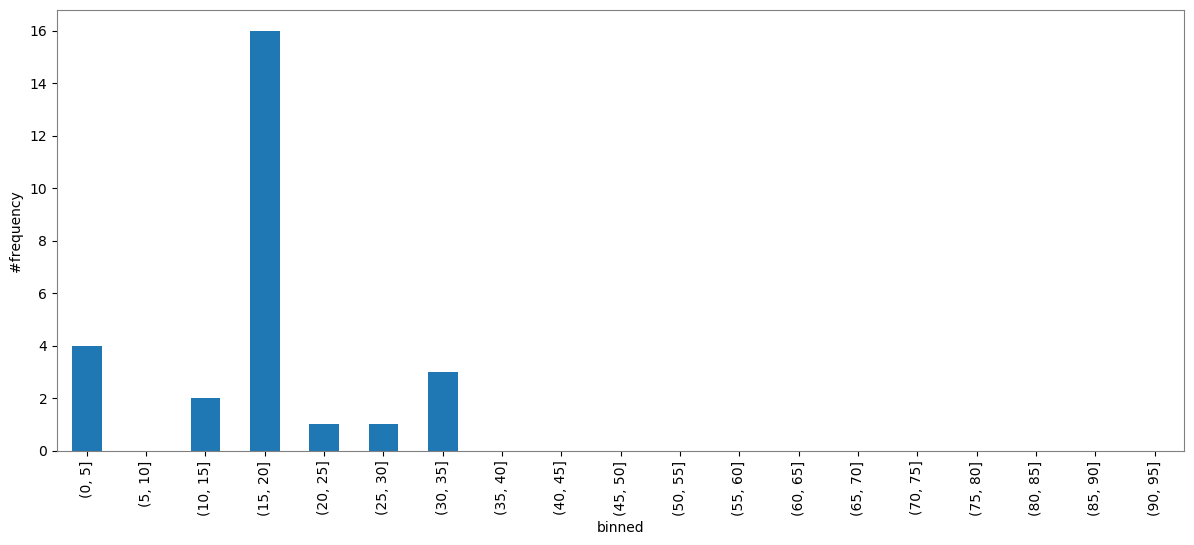

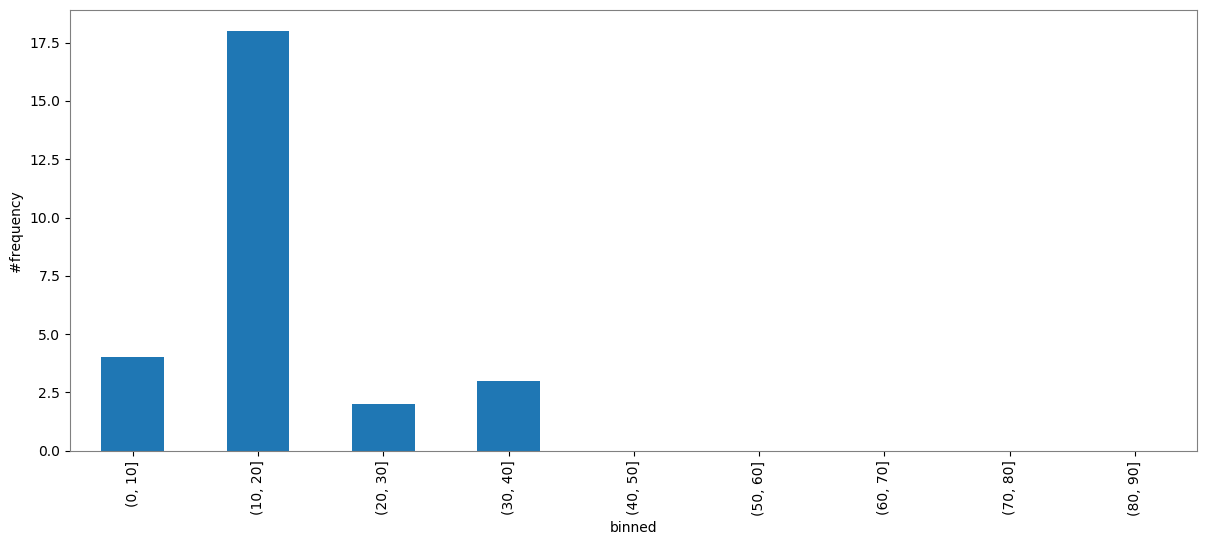

In [47]:
for degrees_of_control in [5,10]:

    bins = list (range(0,100,degrees_of_control))
    data['binned'] = pd.cut(data['percent'], bins)
    (fig,ax) = init_fig()
    data.groupby('binned').size().plot(kind="bar",ax=ax)

    # xlabel
    label = '#frequency '.format(degrees_of_control)
    ax.set_ylabel(label);
# ax.set_ylabel('# Site load (/24 netblocks)');

In [48]:
data.groupby('binned').size()

binned
(0, 10]      4
(10, 20]    18
(20, 30]     2
(30, 40]     3
(40, 50]     0
(50, 60]     0
(60, 70]     0
(70, 80]     0
(80, 90]     0
dtype: int64